In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os, gc
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows",200)
pd.set_option("display.max_columns",50)


In [2]:
train_df = pd.read_csv('train_aox2Jxw/train.csv')
test_df  = pd.read_csv('test_bqCt9Pv.csv')
sub      = pd.read_csv('sample_submission_24jSKY6.csv')
info_df  = pd.read_excel('train_aox2Jxw/Data Dictionary.xlsx')

train_test = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

train_test.shape, train_df.shape, test_df.shape, sub.shape, info_df.shape

((345546, 41), (233154, 41), (112392, 40), (112392, 2), (41, 3))

# Only `Employment.Type` have `NaN` values

## Add flag to diffrentiate b/w train and test

In [3]:
def distplot_it(df, flag_col, col):
    """
    Args:
        df      : data-frame
        col     : columnn for distplot
        flag_col: flag to represent train or test
    return: 
        distplot with flag[0/1]
    """
    plt.figure(figsize=(16,4))
    sns.distplot(df[df[flag_col] == 1][col], hist=False, label='train')
    sns.distplot(df[df[flag_col] == 0][col], hist=False, label='test')
    _ = plt.xticks(rotation='vertical')
    
def countplot_it(df, flag_col, col):
    """
    Args:
        df      : data-frame
        col     : columnn for distplot
        flag_col: flag to represent train or test
    return: 
        distplot with flag[0/1]
    """
    plt.figure(figsize=(16,4))
    sns.countplot(x=col, hue=flag_col, data=train_test)
    _ = plt.xticks(rotation='vertical')
    


In [4]:
def remove_and_fill_outlier(df, flag):
    """fill outlier with the nan values"""
    """
    Args:
        df  : feature
        flag: string ['lower','upper','both']
    return: array containing new feature
    """
    lower_bound = np.percentile(df, q=1)
    upper_bound = np.percentile(df, q=99)
    print("low: ", np.round(lower_bound,2), "   high: ", np.round(upper_bound,2))
    if flag == 'upper':
        new = np.where(df>upper_bound, np.nan, df)
    elif flag == 'lower':
        new = np.where(df<lower_bound, np.nan, df)
    else: # when both are selected
        new = np.where(df>upper_bound, np.nan, df)
        new = np.where(new<lower_bound, np.nan, new)
    print("null count: ", pd.DataFrame(new).isnull().sum().values)
    return new

def get_quantile(df, col, q1, q2):
    lower_bound = np.percentile(df[col], q=q1)
    upper_bound = np.percentile(df[col], q=q2)
    print("low: ", lower_bound)
    print("high: ", upper_bound)
    
def remove_outlier(df, col, flag):
    """fill outlier with the nan values"""
    """
    Args:
        df  : feature
        flag: string ['lower','upper','both']
    return: array containing new feature
    """
    lower_bound = np.percentile(df[col], q=1)
    upper_bound = np.percentile(df[col], q=99)
    print("low: ", np.round(lower_bound,2), "   high: ", np.round(upper_bound,2))
    print("check shape: ", df.shape[0], "==>", end=" ")
    if flag == 'upper':
        df = df[df[col]<upper_bound]
    elif flag == 'lower':
        df = df[df[col]>lower_bound]
    else: # when both are selected
        df = df[df[col]<upper_bound]
        df = df[df[col]>lower_bound]
    print(df.shape[0])
    return d

# Handling `12` catgorical variables

In [5]:
train_test['train_flag'] = 0
train_test['train_flag'].iloc[:train_df.shape[0]] = 1
train_test.train_flag.value_counts()

1    233154
0    112392
Name: train_flag, dtype: int64

In [6]:
train_test['Date.of.Birth'] = train_test['Date.of.Birth'].apply(
    lambda x: str(x)[:-2]+'20'+str(x)[-2:] if str(x)[-2:] == '00' \
    else str(x)[:-2]+'19'+str(x)[-2:])
train_test['date_of_birth']  = pd.to_datetime(pd.Series(train_test['Date.of.Birth']))
train_test.drop('Date.of.Birth', axis=1, inplace=True)

In [7]:
train_test['DisbursalDate_new'] = pd.to_datetime(
    pd.Series(train_test['DisbursalDate'].apply(lambda x: str(x)[:-3])), 
    format="%d-%m")

train_test.DisbursalDate_new = train_test.DisbursalDate_new.apply(
    lambda dt: dt.replace(year=2018))

train_test['disbursal_week']  = train_test['DisbursalDate_new'].dt.week
train_test['disbursal_day']   = train_test['DisbursalDate_new'].dt.day
train_test['disbursal_month'] = train_test['DisbursalDate_new'].dt.month

# train_test.DisbursalDate_new.unique()

In [8]:
train_test['age(in years)'] = ((train_test['DisbursalDate_new'] - \
                    train_test['date_of_birth'])/365) / np.timedelta64(1, 'D')
train_test['age(in years)'] = train_test['age(in years)'].astype('int')
print(train_test['age(in years)'][:5])

train_test['age(in month)'] = ((train_test['DisbursalDate_new'] - \
                    train_test['date_of_birth'])/30) / np.timedelta64(1, 'D')
train_test['age(in month)'] = train_test['age(in years)'].astype('int')
print(train_test['age(in month)'][:5])

0    34
1    33
2    32
3    24
4    41
Name: age(in years), dtype: int64
0    34
1    33
2    32
3    24
4    41
Name: age(in month), dtype: int64


In [9]:
train_test['credit_hist_year'] = train_test['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[0][:-3])
train_test['credit_hist_month']= train_test['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[1][:-3])

train_test['credit_hist_year'] = train_test['credit_hist_year'].astype('int')
train_test['credit_hist_month']= train_test['credit_hist_month'].astype('int')

train_test['credit_hist_total_month']= train_test['credit_hist_month'] + \
                                        train_test['credit_hist_year']*12

train_test['loan_tenure_year'] = train_test['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[0][:-3])
train_test['loan_tenure_month']= train_test['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[1][:-3])

train_test['loan_tenure_year'] = train_test['loan_tenure_year'].astype('int')
train_test['loan_tenure_month']= train_test['loan_tenure_month'].astype('int')

train_test['loan_tenure_total_month']= train_test['loan_tenure_month'] + \
                                        train_test['loan_tenure_year']*12

# train_test.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1, inplace=True)


In [10]:
train_test['Employment.Type'].fillna('Self employed', inplace=True)


In [11]:
col = 'PRI.NO.OF.ACCTS'
new_col = 'pri_no_of_accts'

bins = pd.IntervalIndex.from_tuples([(-1,0),(0,1),(1,2),(2,3),(3,4),(4,8),(8,15),(15,1000)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)

train_test.drop(col, axis=1, inplace=True)
train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack()


(-1, 0]       174843
(0, 1]         51914
(4, 8]         30184
(1, 2]         29253
(2, 3]         19409
(8, 15]        17566
(3, 4]         13758
(15, 1000]      8619
Name: pri_no_of_accts, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 3, closed='right')
 Interval(3, 4, closed='right') Interval(4, 8, closed='right')
 Interval(8, 15, closed='right') Interval(15, 1000, closed='right')]


loan_default,0.0,1.0
pri_no_of_accts,,
0,89898,27052
1,27241,7737
2,15535,4249
3,10377,2638
4,7535,1788
5,16791,3969
6,10026,2176
7,5140,1002


In [12]:
col = 'PRI.ACTIVE.ACCTS'

bins = pd.IntervalIndex.from_tuples([(-1, 0),(0, 1),(1,3),(3,6),(6,10),(10,500)])
train_test['no_of_acc'] = pd.cut(train_test[col], bins)
print(train_test['no_of_acc'].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test['no_of_acc'] = le.fit_transform(train_test['no_of_acc'])
print(le.classes_)

train_test.drop(col, axis=1, inplace=True)
train_test.groupby(['no_of_acc','loan_default'])['loan_default'].count().unstack()

(-1, 0]      205427
(0, 1]        62095
(1, 3]        49528
(3, 6]        21052
(6, 10]        5835
(10, 500]      1609
Name: no_of_acc, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 3, closed='right') Interval(3, 6, closed='right')
 Interval(6, 10, closed='right') Interval(10, 500, closed='right')]


loan_default,0.0,1.0
no_of_acc,,
0,105965,31051
1,32873,9182
2,26821,6996
3,12173,2617
4,3659,609
5,1052,156


In [13]:
col = 'PRI.OVERDUE.ACCTS'
new_col = 'no_of_acc_overdue'
bins = pd.IntervalIndex.from_tuples([(-1, 0),(0, 1),(1,2),(2,5),(5,500)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)
print(train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack())

train_test.drop(col, axis=1, inplace=True)


(-1, 0]     306917
(0, 1]       29378
(1, 2]        6275
(2, 5]        2642
(5, 500]       334
Name: no_of_acc_overdue, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 5, closed='right')
 Interval(5, 500, closed='right')]
loan_default          0.0    1.0
no_of_acc_overdue               
0                  163471  43408
1                   14588   5382
2                    3061   1241
3                    1243    529
4                     180     51


In [14]:
train_test.drop('MobileNo_Avl_Flag', axis=1, inplace=True)


In [15]:
# bureau description and corresponding score
mapping = {
        'No Bureau History Available'                            :'not_enough_info',# 00
        'Not Scored: More than 50 active Accounts found'         :'not_enough_info',# 11
        'Not Scored: No Activity seen on the customer (Inactive)':'not_enough_info',# 16
        'Not Scored: No Updates available in last 36 months'     :'not_enough_info',# 18 
        'Not Scored: Not Enough Info available on the customer'  :'not_enough_info',# 17
        'Not Scored: Only a Guarantor'                           :'not_enough_info',# 14
        'Not Scored: Sufficient History Not Available'           :'not_enough_info' # 15
       }

train_test['Bureau_desc'] = train_test['PERFORM_CNS.SCORE.DESCRIPTION'].replace(mapping)

use_index = train_test[['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE']][
    train_test['Bureau_desc'] == 'not_enough_info']['PERFORM_CNS.SCORE'].index
train_test['bureau_score'] = train_test['PERFORM_CNS.SCORE']
train_test.loc[use_index,'bureau_score'] = 0


train_test.drop(['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE'], 
                axis=1, inplace=True)


In [16]:
col = 'NEW.ACCTS.IN.LAST.SIX.MONTHS'
new_col = 'new_acc_past_month'

bins = pd.IntervalIndex.from_tuples([(-1,0),(0,1),(1,2),(2,3),(3,4),(4,50)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)

train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack()
train_test.drop(col, axis=1, inplace=True)

(-1, 0]    272341
(0, 1]      45965
(1, 2]      15618
(2, 3]       6161
(4, 50]      2825
(3, 4]       2636
Name: new_acc_past_month, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 3, closed='right')
 Interval(3, 4, closed='right') Interval(4, 50, closed='right')]


# numeric columns

In [17]:
def print_it(col):
    print(col)
    print("train-test:")
    get_quantile(train_test,col,q1,q2)
    print("train_df  :")
    get_quantile(train_df,col,q1,q2)
    print("*"*30)

q1 = 1
q2 = 99
col = 'PRI.SANCTIONED.AMOUNT'
print_it(col)

col = 'PRI.DISBURSED.AMOUNT'
print_it(col)

col = 'PRI.SANCTIONED.AMOUNT'
print_it(col)

col = 'PRI.DISBURSED.AMOUNT'
print_it(col)

col = 'PRI.CURRENT.BALANCE'
print_it(col)

col = 'SEC.CURRENT.BALANCE'
print_it(col)

col = 'SEC.DISBURSED.AMOUNT'
print_it(col)

col = 'PRIMARY.INSTAL.AMT'
print_it(col)

col = 'SEC.CURRENT.BALANCE'
print_it(col)




PRI.SANCTIONED.AMOUNT
train-test:
low:  0.0
high:  3363234.2999999993
train_df  :
low:  0.0
high:  3467119.3700000034
******************************
PRI.DISBURSED.AMOUNT
train-test:
low:  0.0
high:  3366855.2999999924
train_df  :
low:  0.0
high:  3457573.880000001
******************************
PRI.SANCTIONED.AMOUNT
train-test:
low:  0.0
high:  3363234.2999999993
train_df  :
low:  0.0
high:  3467119.3700000034
******************************
PRI.DISBURSED.AMOUNT
train-test:
low:  0.0
high:  3366855.2999999924
train_df  :
low:  0.0
high:  3457573.880000001
******************************
PRI.CURRENT.BALANCE
train-test:
low:  0.0
high:  2835998.64999999
train_df  :
low:  0.0
high:  2917864.330000001
******************************
SEC.CURRENT.BALANCE
train-test:
low:  0.0
high:  6226.499999999884
train_df  :
low:  0.0
high:  19733.780000000086
******************************
SEC.DISBURSED.AMOUNT
train-test:
low:  0.0
high:  30397.29999999993
train_df  :
low:  0.0
high:  47544.83000000022
***

In [18]:
train_test.shape, train_df.shape, test_df.shape, train_df.shape[0]+test_df.shape[0]

((345546, 53), (233154, 41), (112392, 40), 345546)

In [19]:
def replace_outliers(df, low, high):
    """
    Args:
        df  : array
        low : 01% range
        high: 99% range
    return:
        an array, where outliers are replaced by the end ranges
    """
    df = np.where(df>high, high, df)
    df = np.where(df<low, low, df)
    print(df)
    
x = [1,2,3,4,54,5,7,78,9,9,33,5,6,9]
replace_outliers(np.array(x), 3,7)

[3 3 3 4 7 5 7 7 7 7 7 5 6 7]


In [20]:
df = pd.DataFrame(data=x, columns=['x'])
print(x)
df[df.x > 7] = 7
df[df.x < 3] = 3
df

[1, 2, 3, 4, 54, 5, 7, 78, 9, 9, 33, 5, 6, 9]


,x
0,3
1,3
2,3
3,4
4,7
5,5
6,7
7,7
8,7
9,7


In [21]:
def count_negative(df, col):
    print(col, "==", df[df[col]<0].shape[0])
print("count negative numbers")

col = 'PRI.SANCTIONED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.DISBURSED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.SANCTIONED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.DISBURSED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.CURRENT.BALANCE'; count_negative(train_test, col)
col = 'SEC.CURRENT.BALANCE'; count_negative(train_test, col)
col = 'SEC.DISBURSED.AMOUNT'; count_negative(train_test, col)
col = 'PRIMARY.INSTAL.AMT'; count_negative(train_test, col)
col = 'SEC.CURRENT.BALANCE'; count_negative(train_test, col)



count negative numbers
PRI.SANCTIONED.AMOUNT == 1
PRI.DISBURSED.AMOUNT == 0
PRI.SANCTIONED.AMOUNT == 1
PRI.DISBURSED.AMOUNT == 0
PRI.CURRENT.BALANCE == 666
SEC.CURRENT.BALANCE == 66
SEC.DISBURSED.AMOUNT == 0
PRIMARY.INSTAL.AMT == 0
SEC.CURRENT.BALANCE == 66


In [22]:
def print_it(col):
    print(col)
#     print("train-test:")
    get_quantile(train_test,col,q1,q2)
#     print("train_df  :")
#     get_quantile(train_df,col,q1,q2)
    print("*"*30)

q1 = 1
q2 = 99
col = 'PRI.SANCTIONED.AMOUNT'
print_it(col)

col = 'PRI.DISBURSED.AMOUNT'
print_it(col)

col = 'PRI.SANCTIONED.AMOUNT'
print_it(col)

col = 'PRI.DISBURSED.AMOUNT'
print_it(col)

col = 'PRI.CURRENT.BALANCE'
print_it(col)

col = 'SEC.CURRENT.BALANCE'
print_it(col)

col = 'SEC.DISBURSED.AMOUNT'
print_it(col)

col = 'PRIMARY.INSTAL.AMT'
print_it(col)

col = 'SEC.CURRENT.BALANCE'
print_it(col)




PRI.SANCTIONED.AMOUNT
low:  0.0
high:  3363234.2999999993
******************************
PRI.DISBURSED.AMOUNT
low:  0.0
high:  3366855.2999999924
******************************
PRI.SANCTIONED.AMOUNT
low:  0.0
high:  3363234.2999999993
******************************
PRI.DISBURSED.AMOUNT
low:  0.0
high:  3366855.2999999924
******************************
PRI.CURRENT.BALANCE
low:  0.0
high:  2835998.64999999
******************************
SEC.CURRENT.BALANCE
low:  0.0
high:  6226.499999999884
******************************
SEC.DISBURSED.AMOUNT
low:  0.0
high:  30397.29999999993
******************************
PRIMARY.INSTAL.AMT
low:  0.0
high:  240000.0
******************************
SEC.CURRENT.BALANCE
low:  0.0
high:  6226.499999999884
******************************


In [23]:
col = 'PRI.SANCTIONED.AMOUNT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col] < 0][col] = 0
train_test[train_test[col] > 3363234][col] = 3363234
print(train_test.shape)

col = 'PRI.DISBURSED.AMOUNT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col] < 0][col] = 0
train_test[train_test[col] > 3366855][col] = 3366855
print(train_test.shape)

col = 'PRI.CURRENT.BALANCE'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>2835998][col] = 2835998
print(train_test.shape)

col = 'SEC.CURRENT.BALANCE'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>6226][col] = 6226
print(train_test.shape)

col = 'SEC.DISBURSED.AMOUNT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>30397][col] = 30397
print(train_test.shape)

col = 'SEC.CURRENT.BALANCE'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0 
train_test[train_test[col]>6226.5][col] = 6226.5
print(train_test.shape)

col = 'PRIMARY.INSTAL.AMT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>240000][col] = 240000
print(train_test.shape)


(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)


In [24]:
col1 = 'PRI.SANCTIONED.AMOUNT'
col2 = 'PRI.DISBURSED.AMOUNT'
train_test['pay_by_yourself'] = train_test[col2] - train_test[col1]

new_col1 = 'obtained_amount_per_month'
new_col2 = 'obtained_amount_per_year'
train_test[new_col1] = train_test[col2]/(1 + train_test['loan_tenure_total_month'])
train_test[new_col2] = train_test[col2]/(1 + train_test['loan_tenure_year'])


In [25]:
print(train_test.shape[0], "==>", end=" ")
drop_cols = ['SEC.OVERDUE.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.NO.OF.ACCTS', 'VoterID_flag', 
             'Driving_flag', 'Passport_flag', 'SEC.INSTAL.AMT']
train_test.drop(drop_cols, axis=1, inplace=True)
print(train_test.shape[0])

345546 ==> 345546


In [26]:
############## Simple aggregation w/o time compomnenet###########
print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id'],how='left')

print(train_test.shape)


(345546, 49) ==> (345546, 52)


# Aggregation with time compomnenet
    - It have different distribution for train and test

In [27]:
############## Aggregation with time compomnenet ###########

print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id','disbursal_week'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID','disbursal_week'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id','disbursal_week'],how='left')

print(train_test.shape)

(345546, 52) ==> (345546, 55)


## aggregation date wise

In [35]:
train_test1 = train_test.copy()
############## Simple aggregation w/o time compomnenet###########
print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_disbursedDate_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['DisbursalDate_new'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_disbursedDate_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['DisbursalDate_new'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_disbursedDate_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['DisbursalDate_new'],how='left')

print(train_test.shape)


(345546, 55) ==> (345546, 58)


In [36]:
############## Aggregation with time compomnenet ###########

print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id','DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_date_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id','DisbursalDate_new'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID','DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_date_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID','DisbursalDate_new'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id','DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_date_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id','DisbursalDate_new'],how='left')

print(train_test.shape)

(345546, 58) ==> (345546, 61)


In [44]:
stat_cols = ['PRI.CURRENT.BALANCE','PRI.DISBURSED.AMOUNT','PRI.SANCTIONED.AMOUNT',
             'PRIMARY.INSTAL.AMT','asset_cost','disbursed_amount']

print(train_test.shape, "==>", end=" ")

train_test['stat_mean']   = train_test[stat_cols].mean(axis=1)
train_test['stat_median'] = train_test[stat_cols].median(axis=1)
train_test['stat_skew']   = train_test[stat_cols].skew(axis=1)
train_test['stat_std']    = train_test[stat_cols].std(axis=1)
print(train_test.shape)

(345546, 61) ==> (345546, 65)


In [45]:
assert train_test.shape[0] == train_df.shape[0]+test_df.shape[0]
print("shape are equal")

shape are equal


In [46]:
train_test.to_csv('store_data/train_test_save6.csv', index=None)

In [48]:
drop_cols = ['date_of_birth', 'Employee_code_ID','DisbursalDate',
             'CREDIT.HISTORY.LENGTH', 'AVERAGE.ACCT.AGE', 'DisbursalDate_new']

train_test.drop(drop_cols, axis=1, inplace=True)
train_test.head(10)

,Aadhar_flag,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Employment.Type,NO.OF_INQUIRIES,PAN_flag,PRI.CURRENT.BALANCE,PRI.DISBURSED.AMOUNT,PRI.SANCTIONED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.CURRENT.BALANCE,SEC.DISBURSED.AMOUNT,SEC.SANCTIONED.AMOUNT,State_ID,UniqueID,asset_cost,branch_id,disbursed_amount,loan_default,ltv,manufacturer_id,supplier_id,train_flag,disbursal_week,disbursal_day,...,pri_no_of_accts,no_of_acc,no_of_acc_overdue,Bureau_desc,bureau_score,new_acc_past_month,pay_by_yourself,obtained_amount_per_month,obtained_amount_per_year,manufac_disbursed_mean,state_disbursed_mean,branch_disbursed_mean,manufac_week_disbursed_mean,state_week_disbursed_mean,branch_week_disbursed_mean,manufac_disbursedDate_mean,state_disbursedDate_mean,branch_disbursedDate_mean,manufac_date_disbursed_mean,state_date_disbursed_mean,branch_date_disbursed_mean,stat_mean,stat_median,stat_skew,stat_std
0,1,1441,0,Salaried,0,0,0,0,0,0,0,0,0,6,420825,58400,67,50578,0.0,89.55,45,22807,1,31,3,...,0,0,0,not_enough_info,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,46057.862745,49444.791667,50931.649718,51740.371549,51740.371549,51740.371549,46174.107895,49978.261224,50470.271429,18163.000000,0.0,1.001508,28246.510121
1,1,1502,1,Self employed,0,0,27600,50200,50200,1991,0,0,0,6,537409,65550,67,47145,1.0,73.23,45,22807,1,39,26,...,1,1,1,I-Medium Risk,598,0,0,2091.666667,25100.0,49787.567424,52013.951394,52479.194149,50363.817038,52137.326040,52618.855381,55268.452152,55268.452152,55268.452152,50183.237553,51734.682505,52383.056738,40447.666667,48672.5,-1.094696,22401.674818
2,1,1497,0,Self employed,0,0,0,0,0,0,0,0,0,6,417566,61360,67,53278,0.0,89.63,45,22807,1,31,1,...,0,0,0,not_enough_info,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,46057.862745,49444.791667,50931.649718,51430.433841,51430.433841,51430.433841,45514.829730,48707.741525,51593.740000,19106.333333,0.0,1.000350,29709.537335
3,1,1501,0,Self employed,1,0,0,0,0,31,0,0,0,6,624493,66113,67,57513,1.0,88.48,45,22807,1,43,26,...,3,0,0,L-Very High Risk,305,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,51074.109043,52919.600166,53079.192621,56431.085599,56431.085599,56431.085599,51439.126253,53916.178801,54048.882812,20609.500000,15.5,0.999520,32031.752863
4,1,1495,0,Self employed,1,0,0,0,0,0,0,0,0,6,539055,60300,67,52378,1.0,88.39,45,22807,1,39,26,...,0,0,0,not_enough_info,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,50363.817038,52137.326040,52618.855381,55268.452152,55268.452152,55268.452152,50183.237553,51734.682505,52383.056738,18779.666667,0.0,1.000176,29200.991775
5,1,1501,0,Self employed,0,0,0,0,0,1347,0,0,0,6,518279,61900,67,54513,0.0,89.66,45,22807,1,38,19,...,2,0,0,A-Very Low Risk,825,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,49758.146003,51896.895097,52035.252988,54620.758239,54620.758239,54620.758239,49890.925275,51398.057944,50720.502183,19626.666667,673.5,0.993295,29979.510708
6,1,1502,0,Salaried,0,0,0,0,0,0,0,0,0,6,529269,61500,67,46349,0.0,76.42,45,22807,1,38,23,...,0,0,0,not_enough_info,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,49758.146003,51896.895097,52035.252988,54673.567866,54673.567866,54673.567866,50553.881657,52338.203333,54072.175000,17974.833333,0.0,1.091405,28255.661383
7,1,1501,0,Salaried,0,0,72879,74500,74500,0,0,0,0,6,510278,61900,67,43894,0.0,71.89,45,22807,1,37,16,...,1,1,0,not_enough_info,0,0,0,24833.333333,74500.0,49787.567424,52013.951394,52479.194149,49004.830558,51298.443350,51592.913522,54366.907428,54366.907428,54366.907428,49073.647783,51402.179894,51609.480769,54612.166667,67389.5,-1.702601,29241.099120
8,1,1497,0,Self employed,1,0,-41,365384,365384,0,0,0,0,6,490213,61973,67,53713,0.0,89.56,45,22807,1,36,5,...,1,1,0,D-Very Low Risk,718,0,0,6410.245614,73076.8,49787.567424,52013.951394,52479.194149,47554.614634,49737.637531,50803.452055,52735.456151,52735.456151,52735.456151,47837.335821,50222.447876,50349.047059,141068.833333,57843.0,0.873798,175689.602005
9,0,1492,0,Salaried,

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col = 'Bureau_desc'
train_test[col] = le.fit_transform(train_test[col])
print(le.classes_)
col = 'Employment.Type'
train_test[col] = le.fit_transform(train_test[col])
print(le.classes_)

['A-Very Low Risk' 'B-Very Low Risk' 'C-Very Low Risk' 'D-Very Low Risk'
 'E-Low Risk' 'F-Low Risk' 'G-Low Risk' 'H-Medium Risk' 'I-Medium Risk'
 'J-High Risk' 'K-High Risk' 'L-Very High Risk' 'M-Very High Risk'
 'not_enough_info']
['Salaried' 'Self employed']


In [50]:
tr_shape = train_df.shape[0]
ts_shape = test_df.shape[0]

del train_df, test_df
gc.collect()

3590

In [51]:
train_df = train_test.iloc[:tr_shape, :]
test_df = train_test.iloc[tr_shape:, :]
test_df.reset_index(drop=True, inplace=True)

tr_unique_ids = train_df.UniqueID
ts_unique_ids = test_df.UniqueID

train_df.shape, test_df.shape

((233154, 59), (112392, 59))

In [52]:
target = train_df['loan_default']

train_df.drop(['loan_default','train_flag','UniqueID'], axis=1, inplace=True)
test_df.drop(['loan_default','train_flag','UniqueID'], axis=1, inplace=True)

train_df.shape, test_df.shape

((233154, 56), (112392, 56))

In [43]:
train_test.dtypes

Aadhar_flag                              int64
Current_pincode_ID                       int64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      int64
Employment.Type                          int64
NO.OF_INQUIRIES                          int64
PAN_flag                                 int64
PRI.CURRENT.BALANCE                      int64
PRI.DISBURSED.AMOUNT                     int64
PRI.SANCTIONED.AMOUNT                    int64
PRIMARY.INSTAL.AMT                       int64
Passport_flag                            int64
SEC.ACTIVE.ACCTS                         int64
SEC.CURRENT.BALANCE                      int64
SEC.DISBURSED.AMOUNT                     int64
SEC.INSTAL.AMT                           int64
SEC.NO.OF.ACCTS                          int64
SEC.OVERDUE.ACCTS                        int64
SEC.SANCTIONED.AMOUNT                    int64
State_ID                                 int64
UniqueID                                 int64
VoterID_flag                             int64
asset_cost   

In [ ]:
def run_cat_small(file_path, train_df, target, test_df, test_ids, sub, depth):
    
    splits = 4
    from sklearn.model_selection import KFold, StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from catboost import Pool, CatBoostClassifier

    features = train_df.columns
    random_seed = 2019
    
    model = CatBoostClassifier(loss_function         = "Logloss", 
                               eval_metric           = "AUC",
                               random_strength       = 1.5,
                               border_count          = 128,
                               scale_pos_weight      = 3.507,
                               depth                 = depth, 
                               early_stopping_rounds = 50,
                               random_seed           = 1337,
                               task_type             = 'CPU', 
    #                            subsample           = 0.7, 
                               iterations            = 10000, 
                               learning_rate         = 0.09,
                               thread_count          = 4
                              )


    n_split = splits
    
    valid_splits = int(train_df.shape[0]/splits)
    indexes = train_df[['disbursal_week', 'disbursal_day']].sort_values(
        by=['disbursal_week', 'disbursal_day'])
    
    train_index = indexes[:-valid_splits].index
    valid_index = indexes[-valid_splits:].index
    
    train_df.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
    test_df.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
    
    y_test_pred = 0

    idx = 0
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
    _train = Pool(X_train, label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid, label=y_valid)#, cat_features=cate_features_index)

    fit_model = model.fit(_train, 
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=100
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, pred)
    print( "  auc = ", score )
    print("="*60)

    y_test_pred = fit_model.predict_proba(test_df)[:,1]


    sub_df = pd.DataFrame({"ID_code":test_ids})
    sub_df["target"] = y_test_pred
    sub_df.columns = sub.columns


    sub_df.to_csv('submission/catboost_{}.csv'.format(file_path), index=None)

    cat_imp = pd.DataFrame(data=[fit_model.feature_names_, 
                                 list(fit_model.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    cat_imp = cat_imp.sort_values(by='imp', ascending=False).head(50)
    plt.figure(figsize=(12,15))
    plt.barh(cat_imp.feature, cat_imp.imp)
    plt.show()
    
    return score

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.5
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=50, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

# sub_df = pd.DataFrame({"ID_code":test_id})
# sub_df["target"] = predictions

# sub_df.columns = sub.columns
# sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

In [78]:
# def run_lgb_small(file_path, train_df, target, test_df, test_ids, sub, depth):
def run_lgb_small(train_df, target, leaves=None):
    
    splits = 4
    from sklearn.model_selection import KFold, StratifiedKFold
    from sklearn.metrics import roc_auc_score
    import lightgbm as lgb

    features = train_df.columns
    random_seed = 2019

    param = {
        'bagging_freq'           : 5,
        'bagging_fraction'       : 0.33,
        'boost_from_average'     : 'false',
        'boost'                  : 'gbdt',
        'feature_fraction'       : 0.3,
        'learning_rate'          : 0.01,
        'max_depth'              : -1,
        'metric'                 : 'auc',
#         'min_data_in_leaf'       : 100,
#         'min_sum_hessian_in_leaf': 10.0,
        'num_leaves'             : 30,
        'num_threads'            : 4,
        'tree_learner'           : 'serial',
        'objective'              : 'binary',
        'verbosity'              : 1,
    #     'lambda_l1'              : 0.001,
        'lambda_l2'              : 0.01
    }   
    if leaves is not None:
        param['num_leaves'] = leaves
        print("using leaves: ", param['num_leaves'])

    n_split = splits
    num_round = 10000

    valid_splits = int(train_df.shape[0]/splits)
    indexes = train_df[['disbursal_week', 'disbursal_day']].sort_values(
        by=['disbursal_week', 'disbursal_day'])
    
    train_index = indexes[:-valid_splits].index
    valid_index = indexes[-valid_splits:].index
    
#     train_df.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
#     test_df.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
    
    y_test_pred = 0

    
#     oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
#                                num_iteration=clf.best_iteration)
#     predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    

#     features = train_df.columns

    idx = 0
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
    
    X_train.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
    X_valid.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
    
    features = X_train.columns

        
    _train = lgb.Dataset(X_train[features], label=y_train,
                          feature_name=list(features))
    _valid = lgb.Dataset(X_valid[features], label=y_valid,
                          feature_name=list(features))

    clf = lgb.train(param, _train, num_round, valid_sets = [_train, _valid], 
                    verbose_eval=200, early_stopping_rounds = 25)

                         
    pred = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
    
    score = roc_auc_score(y_valid, pred)
    print( "  auc = ", score )
    print("="*60)

#     y_test_pred = fit_model.predict_proba(test_df)[:,1]

#     sub_df = pd.DataFrame({"ID_code":test_ids})
#     sub_df["target"] = y_test_pred
#     sub_df.columns = sub.columns

#     sub_df.to_csv('submission/catboost_{}.csv'.format(file_path), index=None)

    lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
    lgb_imp.columns = ['feature','imp']
    lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
    plt.figure(figsize=(12,15))
    plt.barh(lgb_imp.feature, lgb_imp.imp)
    plt.show()
    
    return clf, lgb_imp, X_valid, y_valid

using leaves:  40
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.673592	valid_1's auc: 0.643798
[400]	training's auc: 0.685287	valid_1's auc: 0.649078
[600]	training's auc: 0.69409	valid_1's auc: 0.651792
[800]	training's auc: 0.702056	valid_1's auc: 0.653535
[1000]	training's auc: 0.709319	valid_1's auc: 0.654438
Early stopping, best iteration is:
[1011]	training's auc: 0.709697	valid_1's auc: 0.654495
  auc =  0.6544954422276447


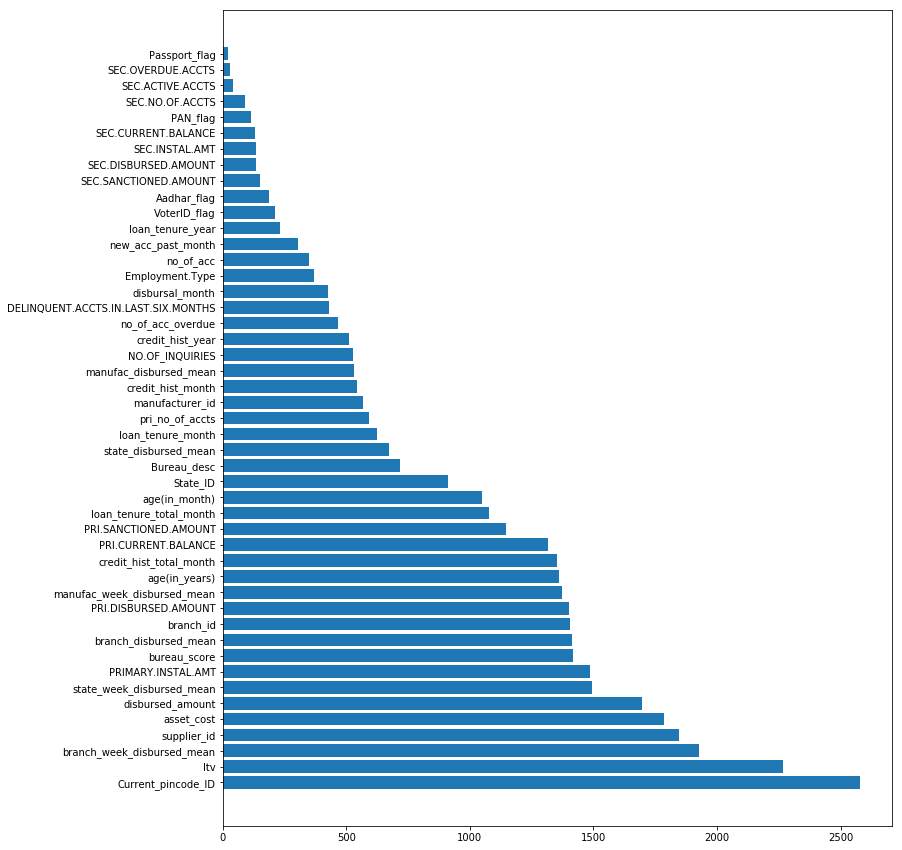

In [66]:
train_df1 = train_df.copy()
lgb1, imp_lgb1 = run_lgb_small(train_df, target, leaves=40)

using leaves:  40
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.671671	valid_1's auc: 0.640479
[400]	training's auc: 0.68305	valid_1's auc: 0.646557
[600]	training's auc: 0.692184	valid_1's auc: 0.649656
[800]	training's auc: 0.700355	valid_1's auc: 0.651197
[1000]	training's auc: 0.707299	valid_1's auc: 0.652375
Early stopping, best iteration is:
[1110]	training's auc: 0.711053	valid_1's auc: 0.652716
  auc =  0.6527158776363003


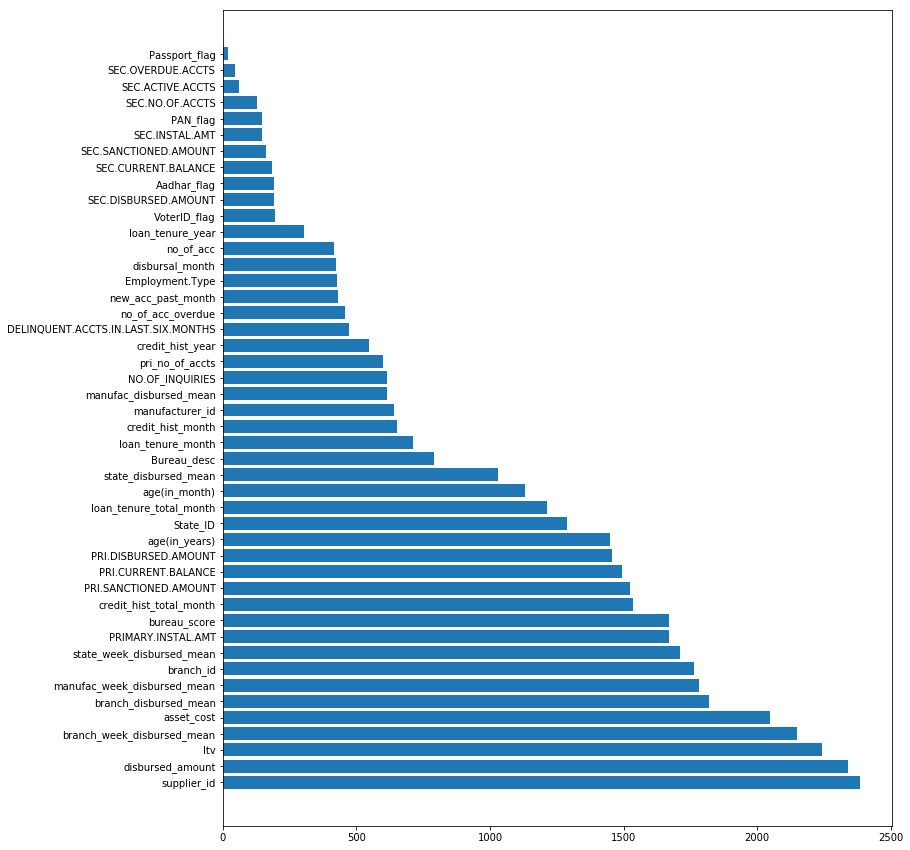

In [79]:
lgb2, imp_lgb2, x_valid, y_valid = run_lgb_small(train_df.drop('Current_pincode_ID', axis=1), 
                               target, leaves=40)

In [73]:
# valid_splits = int(train_df.shape[0]/4)
# indexes = train_df[['disbursal_week', 'disbursal_day']].sort_values(
#     by=['disbursal_week', 'disbursal_day'])

# valid_index = indexes[-valid_splits:].index

# tp = train_df.drop('Current_pincode_ID', axis=1).iloc[valid_index]
# y_valid = target[valid_index]
# print("shape: ", tp.shape, y_valid.shape)


# features = list(set(tp.columns) - set(['disbursal_week', 'disbursal_day']))
# from sklearn.metrics import roc_auc_score
# pred = lgb2.predict(tp[features], num_iteration=lgb2.best_iteration)

# score = roc_auc_score(y_valid, pred)
# print( "  auc = ", score )

shape:  (58288, 48) (58288,)


In [80]:
# features = list(set(tp.columns) - set(['disbursal_week', 'disbursal_day']))
from sklearn.metrics import roc_auc_score
pred = lgb2.predict(x_valid, num_iteration=lgb2.best_iteration)

score = roc_auc_score(y_valid, pred)
print( "  auc = ", score )

  auc =  0.6527158776363003


In [89]:
x_valid1 = x_valid.copy()

In [104]:
feat_cols = list(imp_lgb2.head(10)['feature'].values)
for col in feat_cols:
    index = np.random.permutation(x_valid1.shape[0])
    new = x_valid1[col].iloc[index]
    x_valid[col] = new
#     print(x_valid1[col][:5], new[:5])
    pred = lgb2.predict(x_valid, num_iteration=lgb2.best_iteration)

    score = roc_auc_score(y_valid, pred)
    print( "  auc = ", score )

  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863
  auc =  0.6501324164923863


In [108]:
feat_cols = list(imp_lgb2['feature'].values)
for col in feat_cols:
    index = np.random.permutation(x_valid1.shape[0])
    new = x_valid1[col].iloc[index].values
    x_valid[col] = new
#     print(x_valid1[col][:5], new[:5])
    pred = lgb2.predict(x_valid, num_iteration=lgb2.best_iteration)

    score = roc_auc_score(y_valid, pred)
    print( col.ljust(30), "  auc = ", score )

supplier_id                      auc =  0.5802193901181664
disbursed_amount                 auc =  0.580007784024667
ltv                              auc =  0.5788641908270713
branch_week_disbursed_mean       auc =  0.5789037404921535
asset_cost                       auc =  0.5793577075989269
branch_disbursed_mean            auc =  0.5797843595015575
manufac_week_disbursed_mean      auc =  0.5796327215767946
branch_id                        auc =  0.5810747395416239
state_week_disbursed_mean        auc =  0.58031644473253
PRIMARY.INSTAL.AMT               auc =  0.5797917303207684


In [111]:
feat_cols = list(imp_lgb2['feature'].values)
for col in feat_cols:
    x_valid = x_valid1.copy()
    try:
        index = np.random.permutation(x_valid1.shape[0])
        new = x_valid1[col].iloc[index].values
        x_valid[col] = new
    #     print(x_valid1[col][:5], new[:5])
        pred = lgb2.predict(x_valid, num_iteration=lgb2.best_iteration)

        score = roc_auc_score(y_valid, pred)
        print( col.ljust(30), "  auc = ", score )
    except:
        print("=====", col, "=====")

supplier_id                      auc =  0.6498633470527384
disbursed_amount                 auc =  0.6339006849382811
ltv                              auc =  0.6265802086580797
branch_week_disbursed_mean       auc =  0.6499138689554061
asset_cost                       auc =  0.6482365138420845
branch_disbursed_mean            auc =  0.6450992592664228
manufac_week_disbursed_mean      auc =  0.6493442663331466
branch_id                        auc =  0.6450746804494759
state_week_disbursed_mean        auc =  0.6494636461305963
PRIMARY.INSTAL.AMT               auc =  0.6475272903207594
bureau_score                     auc =  0.6430249082195639
credit_hist_total_month          auc =  0.6482563106536392
PRI.SANCTIONED.AMOUNT            auc =  0.6470561167861797
PRI.CURRENT.BALANCE              auc =  0.6497227841959463
PRI.DISBURSED.AMOUNT             auc =  0.649015432815603
===== age(in_years) =====
State_ID                         auc =  0.6429663522024526
loan_tenure_total_month        

In [113]:
train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])

Aadhar_flag                                2
Current_pincode_ID                      6698
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS       14
Employment.Type                            2
NO.OF_INQUIRIES                           25
PAN_flag                                   2
PRI.CURRENT.BALANCE                    71341
PRI.DISBURSED.AMOUNT                   47909
PRI.SANCTIONED.AMOUNT                  44390
PRIMARY.INSTAL.AMT                     28067
Passport_flag                              2
SEC.ACTIVE.ACCTS                          23
SEC.CURRENT.BALANCE                     3246
SEC.DISBURSED.AMOUNT                    2553
SEC.INSTAL.AMT                          1918
SEC.NO.OF.ACCTS                           37
SEC.OVERDUE.ACCTS                          9
SEC.SANCTIONED.AMOUNT                   2223
State_ID                                  22
VoterID_flag                               2
asset_cost                             46252
branch_id                                 82
disbursed_

In [56]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ankish/anaconda3/h2o_jar/h2o.jar
  Ice root: /tmp/tmp27bs1hsx
  JVM stdout: /tmp/tmp27bs1hsx/h2o_ankish_started_from_python.out
  JVM stderr: /tmp/tmp27bs1hsx/h2o_ankish_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 1 month and 13 days !!!"
H2O cluster name:,H2O_from_python_ankish_gf2tx4
H2O cluster total nodes:,1
H2O cluster free memory:,2.590 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [53]:
valid_splits = int(train_df.shape[0]/5)
indexes = train_df[['disbursal_week', 'disbursal_day']].sort_values(
    by=['disbursal_week', 'disbursal_day'])

train_index = indexes[:-valid_splits].index
valid_index = indexes[-valid_splits:].index

len(train_index), len(valid_index)

(186524, 46630)

In [54]:
# del preds, gbm_model, glm_model, dl_model, drf_model, train, test
gc.collect()

14

In [57]:
train = h2o.H2OFrame(pd.concat([train_df, target], axis=1).drop(
    ['disbursal_week', 'disbursal_day'], axis=1).iloc[train_index])
test  = h2o.H2OFrame(pd.concat([train_df, target], axis=1).drop(
    ['disbursal_week', 'disbursal_day'], axis=1).iloc[valid_index])
print(train.shape, test.shape)

# del train_df1, valid_df
gc.collect()

x = train.columns
y = "loan_default"
x.remove(y)

# ignored_columns = ['UniqueID']
train[y] = train[y].asfactor()
test[y]  = test[y].asfactor()

# aml = H2OAutoML(max_models=20, seed=1337, max_runtime_secs=14400, nfolds=3)
# aml.train(x = x, y = y,
#           training_frame = train,
#           leaderboard_frame = test)
# lb = aml.leaderboard
# lb.head(rows=lb.nrows)

gc.collect()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(186524, 55) (46630, 55)


0

In [58]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.kmeans import H2OKMeansEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator


deeplearning Model Build progress: |██████████████████████████████████████| 100%


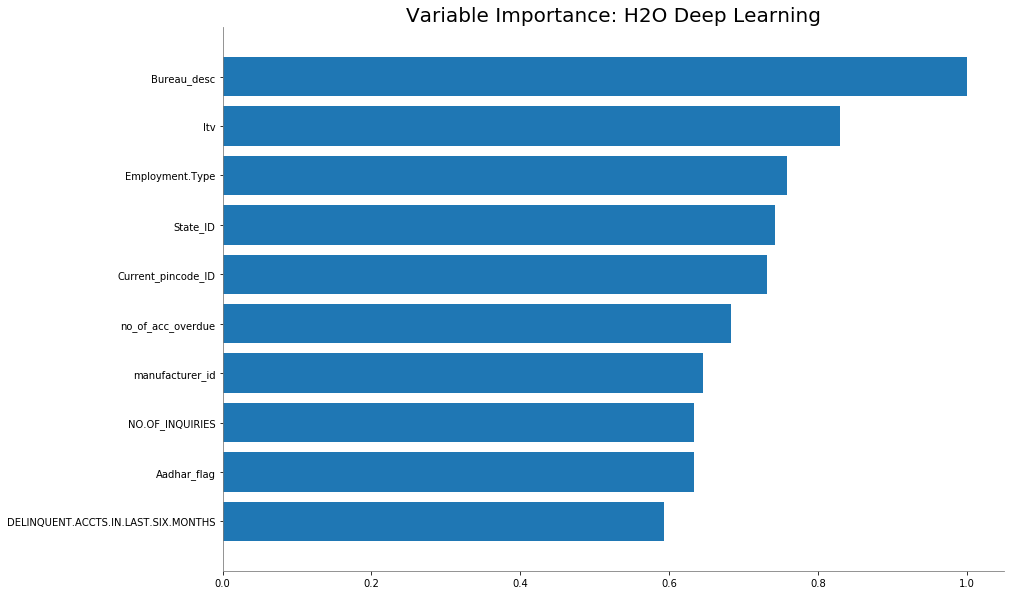

In [75]:
dl_model = H2ODeepLearningEstimator(epochs=50, nfolds=3, seed=1234, 
                                    score_validation_sampling='stratified',
                                    keep_cross_validation_predictions=True,
                                    balance_classes = True,
                                    l2 = 0.0001,
                                    loss = 'cross_entropy',
                                    mini_batch_size = 200,
                                    rate_decay=0.1,
                                    stopping_rounds=2
                                   )
dl_model.train(x, y, training_frame=train, validation_frame=test)
# var_df = pd.DataFrame(dl_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
# print(var_df.shape)
# var_df.head(10)
dl_model.varimp_plot()

deeplearning Model Build progress: |██████████████████████████████████████| 100%


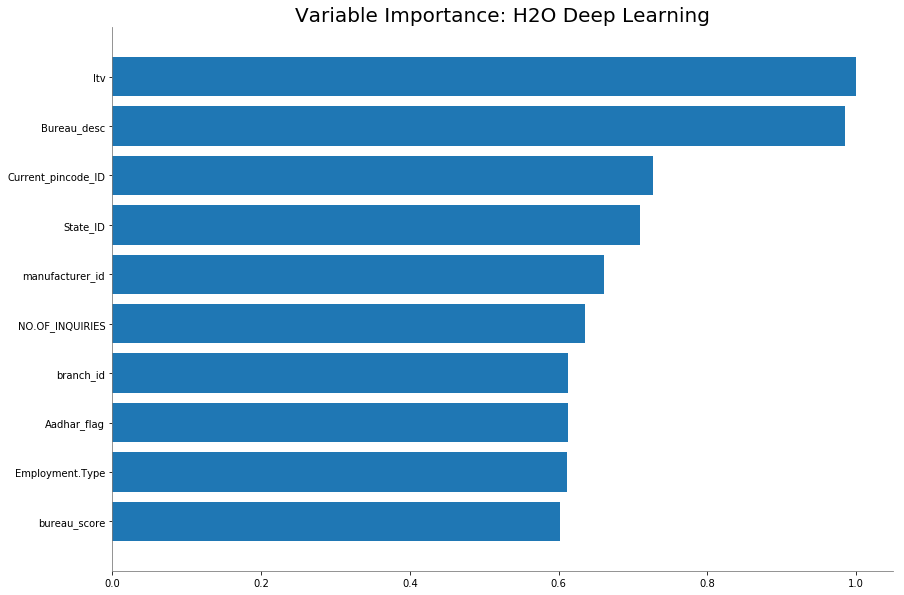

In [76]:
dl_model_deep = H2ODeepLearningEstimator( nfolds=3, seed=1234,
                                          score_validation_sampling='stratified',
                                          keep_cross_validation_predictions=True,
                                          hidden=[100,100],
                                          epochs=50,
                                          balance_classes = True,
                                          l2 = 0.0001,
                                          loss = 'cross_entropy',
                                          mini_batch_size = 200,
                                          rate_decay=0.1,
                                          stopping_rounds=2,
                                          score_validation_samples=10000,
                                          stopping_metric="auc",
                                          stopping_tolerance=0.01
                                        )
dl_model_deep.train(x, y, training_frame=train, validation_frame=test)
# var_df = pd.DataFrame(dl_model_deep.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
# print(var_df.shape)
# var_df.head(10)
dl_model_deep.varimp_plot()

gbm Model Build progress: |███████████████████████████████████████████████| 100%


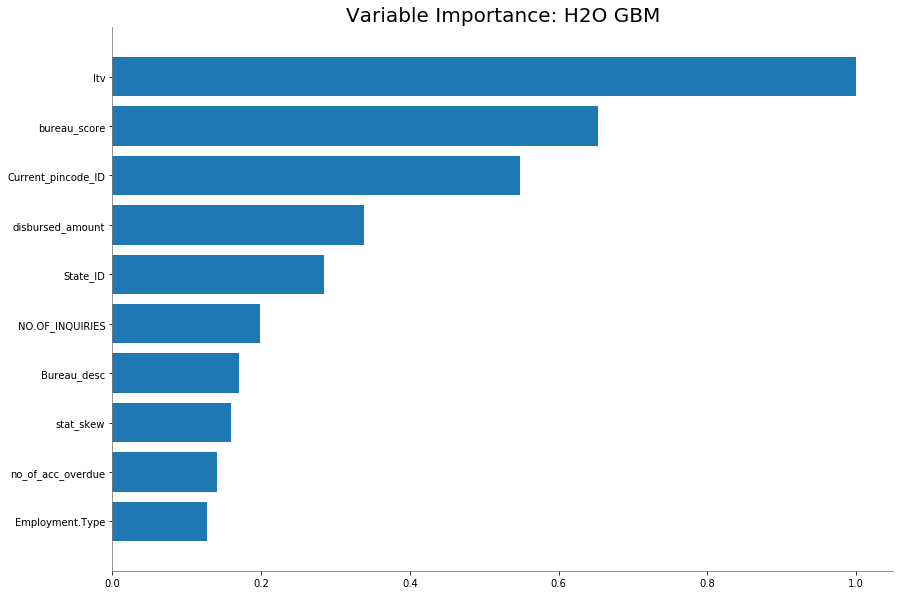

In [77]:
gbm_model = H2OGradientBoostingEstimator(nfolds=3, seed=1234,
                                         balance_classes = True,
                                         col_sample_rate = 0.7,
                                         learn_rate=0.1,
                                         nbins = 128,
                                         fold_assignment='stratified',
                                         stopping_rounds=25,
                                         keep_cross_validation_predictions=True
                                        )
gbm_model.train(x, y, training_frame=train, validation_frame=test)
# var_df = pd.DataFrame(gbm_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
gbm_model.varimp_plot()

gbm Model Build progress: |███████████████████████████████████████████████| 100%


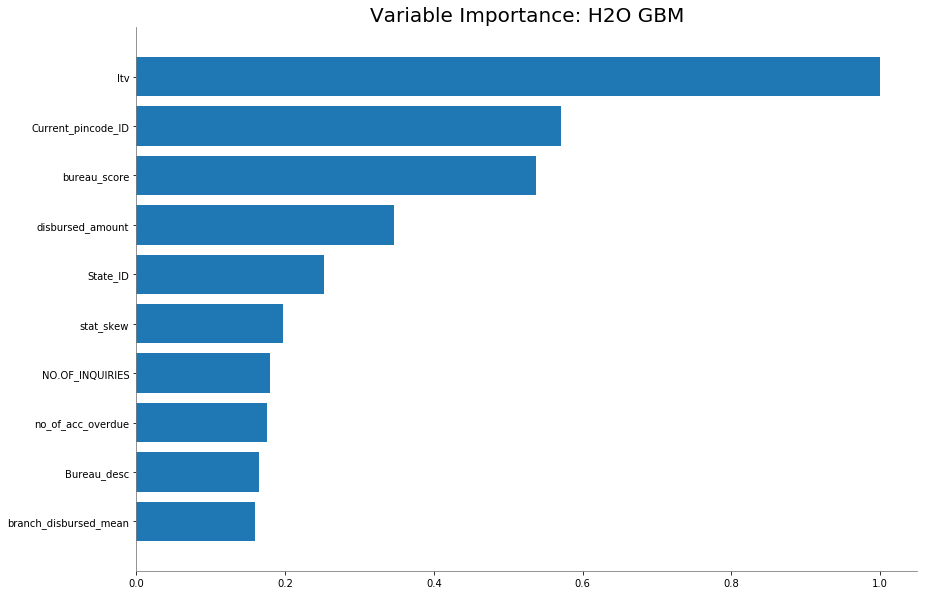

In [78]:
gbm_model_deep = H2OGradientBoostingEstimator(  nfolds=3, seed=1234,
                                                fold_assignment = 'stratified',
#                                                 score_validation_sampling='stratified',
                                                ntrees = 10000,
                                                learn_rate = 0.05,
                                                max_depth = 4,
                                                stopping_rounds = 5, 
                                                stopping_tolerance = 1e-3,
                                                stopping_metric = "AUC",
                                                sample_rate = 0.7,
                                                col_sample_rate = 0.7,
                                                keep_cross_validation_predictions=True
                                             )
gbm_model_deep.train(x, y, training_frame=train, validation_frame=test)
# var_df = pd.DataFrame(gbm_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
gbm_model_deep.varimp_plot()

                                                             

In [ ]:
# model = H2OGradientBoostingEstimator(distribution='bernoulli',
#                                         ntrees=100,
#                                         max_depth=4,
#                                         learn_rate=0.1

drf Model Build progress: |███████████████████████████████████████████████| 100%


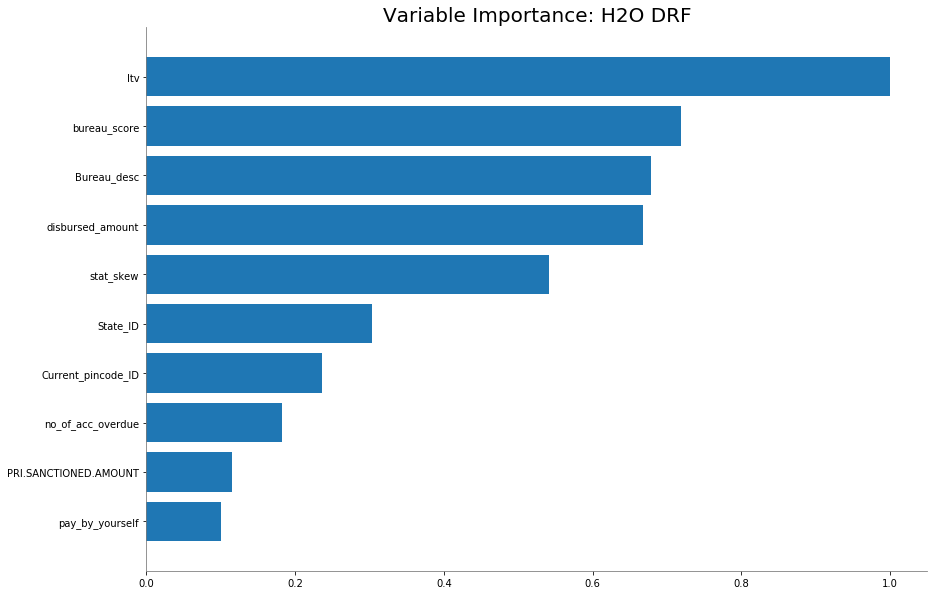

In [79]:
drf_model = H2ORandomForestEstimator(nfolds=3, seed=1234,
                                     ntrees=200,
#                                      score_validation_sampling='stratified',
                                     keep_cross_validation_predictions=True,
                                     fold_assignment = 'stratified',
                                     categorical_encoding='enum',
                                     histogram_type='round_robin',
                                     max_depth = 5
                                    )
drf_model.train(x, y, training_frame=train, validation_frame=test)
# var_df = pd.DataFrame(drf_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
drf_model.varimp_plot()

drf Model Build progress: |███████████████████████████████████████████████| 100%


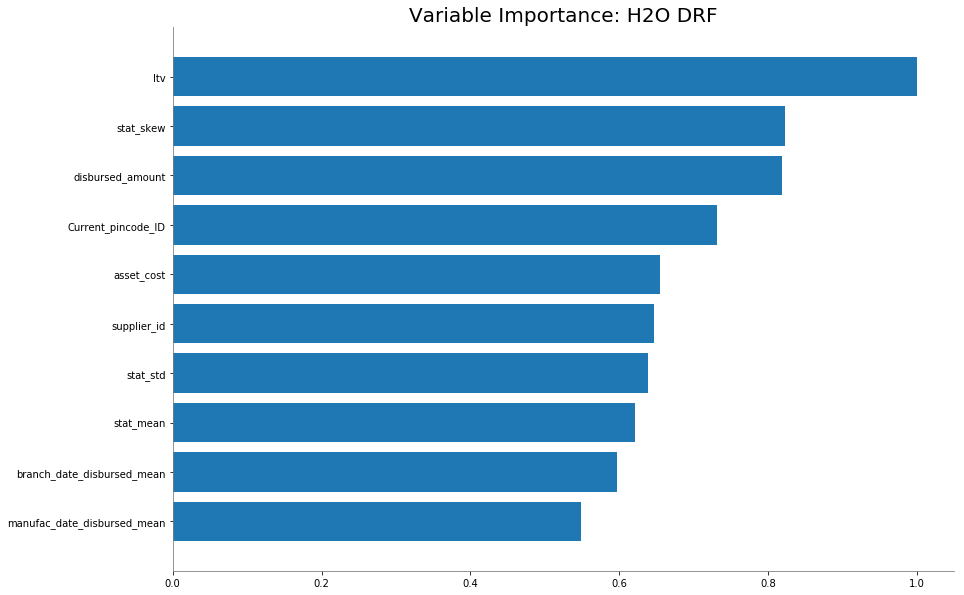

In [80]:
drf_model_deep = H2ORandomForestEstimator( nfolds=3, seed=1234,
                                           keep_cross_validation_predictions=True,
                                           fold_assignment = 'stratified',
                                           histogram_type = 'QuantilesGlobal',
                                           categorical_encoding = 'eigen',
                                           stopping_metric = 'auc',
                                           ntrees = 100,
                                           balance_classes = True
                                           )
drf_model_deep.train(x, y, training_frame=train, validation_frame=test)
drf_model_deep.varimp_plot()

In [ ]:

# drf_model = H2ORandomForestEstimator()
# drf_model.train(x, y, training_frame=train, validation_frame=test)
# # var_df = pd.DataFrame(drf_model.varimp(), 
# #         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
# drf_model.varimp_plot()

glm Model Build progress: |███████████████████████████████████████████████| 100%


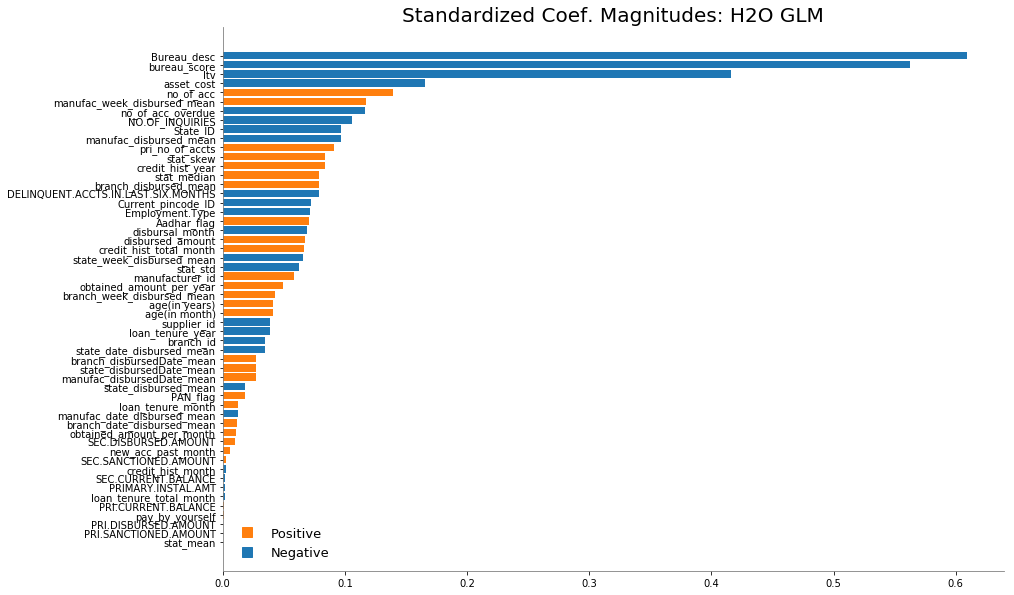

In [81]:
glm_model = H2OGeneralizedLinearEstimator(nfolds=3, seed=1234,
                                          keep_cross_validation_predictions=True,
                                          fold_assignment = 'stratified',
                                          family="binomial")
glm_model.train(x, y, training_frame=train, validation_frame=test)
glm_model.std_coef_plot()

glm Model Build progress: |███████████████████████████████████████████████| 100%


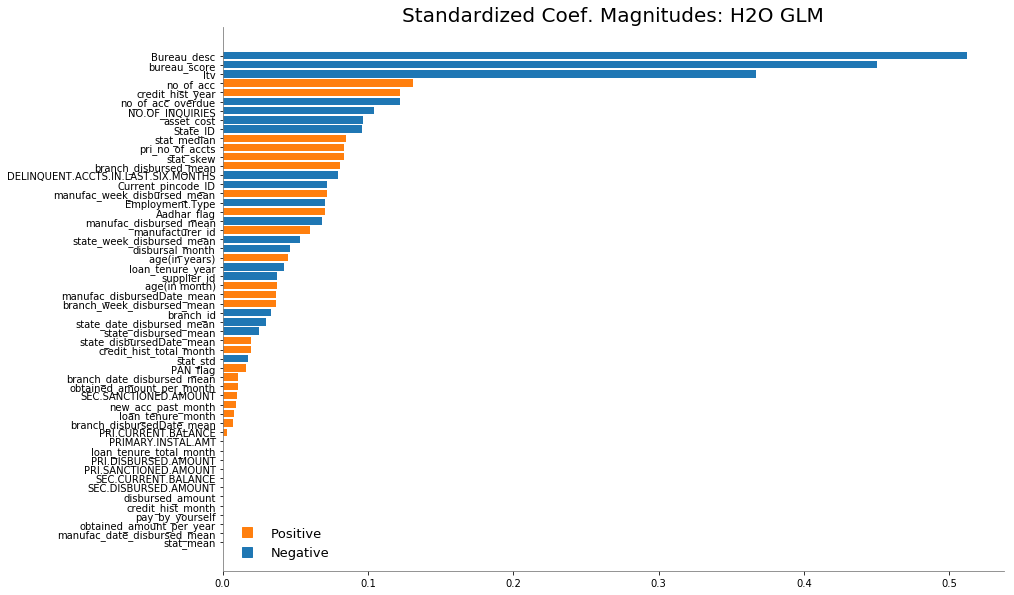

In [82]:

glm_model_bal = H2OGeneralizedLinearEstimator(nfolds=3, seed=1234,
                                              keep_cross_validation_predictions=True,
                                              fold_assignment = 'stratified',
                                              family="binomial", 
                                              lambda_search=True,
                                              balance_classes=True)
glm_model_bal.train(x, y, training_frame=train, validation_frame=test)
glm_model_bal.std_coef_plot()


glm Model Build progress: |███████████████████████████████████████████████| 100%


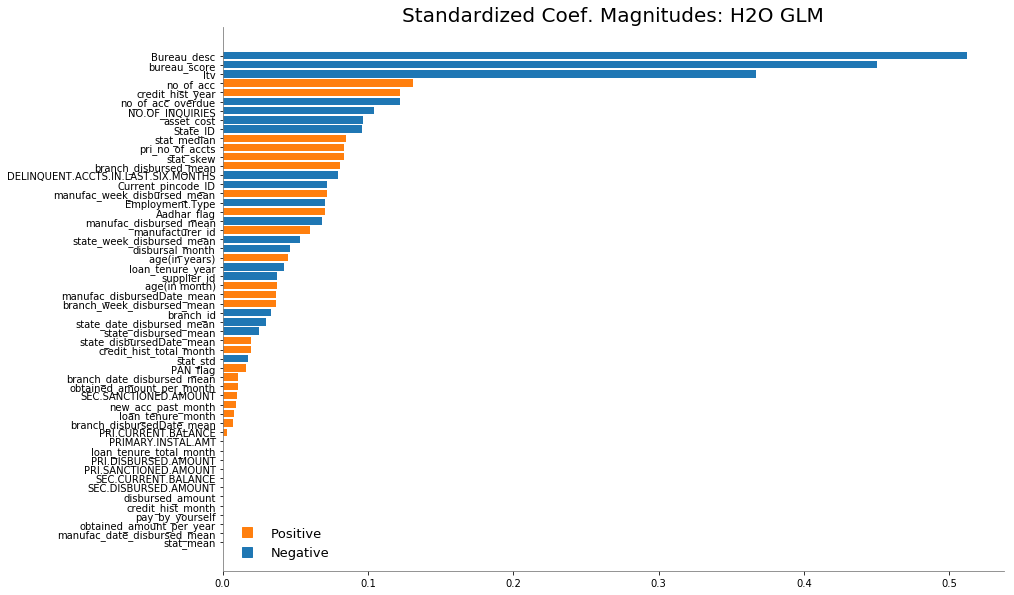

In [83]:
inter_cols = ['ltv','disbursed_amount','asset_cost','supplied_id', 'age(in year)',
     'credit_hist_total_month', 'loan_tenure_total_month','PRI.CURRENT.BALANCE',
     'PRI.DISBURSED.AMOUNT','PRI.SANCTIONED.AMOUNT','Bureau_desc']

drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
    'no_of_acc_overdue','loan_tenure_year','disbursal_month','Aadhar_flag',
    'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
    'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

glm_model_inter = H2OGeneralizedLinearEstimator(nfolds=3, seed=1234,
                                                keep_cross_validation_predictions=True,
                                                fold_assignment = 'stratified',
                                                ignored_columns = drop_cols,
#                                                 interactions = inter_cols,
                                                family="binomial", 
                                                lambda_search=True,
                                                balance_classes=True,
                                                remove_collinear_columns = True)
glm_model_inter.train(x, y, training_frame=train, validation_frame=test)
glm_model_inter.std_coef_plot()


In [276]:
# inter_cols = ['ltv','disbursed_amount','asset_cost','supplied_id', 'age(in year)',
#      'credit_hist_total_month', 'loan_tenure_total_month','PRI.CURRENT.BALANCE',
#      'PRI.DISBURSED.AMOUNT','PRI.SANCTIONED.AMOUNT','Bureau_desc']

# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','loan_tenure_year','disbursal_month','Aadhar_flag',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# glm_model_inter = H2OGeneralizedLinearEstimator(nfolds=2, seed=1234,
#                                                 keep_cross_validation_predictions=True,
#                                                 fold_assignment = 'stratified',
#                                                 ignored_columns = drop_cols,
#                                                 interactions = inter_cols,
#                                                 family="binomial", 
#                                                 lambda_search=True,
#                                                 balance_classes=True,
#                                                 remove_collinear_columns = True)
# glm_model_inter.train(x, y, training_frame=train, validation_frame=test)
# glm_model_inter.std_coef_plot()


In [84]:

drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
    'no_of_acc_overdue','loan_tenure_year','disbursal_month','Aadhar_flag',
    'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
    'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

kmeans_model = H2OKMeansEstimator( k=2, 
#                                    fold_assignment = 'stratified',
                                   keep_cross_validation_predictions=True, 
                                   nfolds = 3,
                                   ignored_columns = drop_cols,
                                   seed=1234,
                                   categorical_encoding = 'one_hot_explicit',
                                   estimate_k = True,
                                   max_iterations = 1000
                                   
                                  )
kmeans_model.train(x, y,training_frame=train, validation_frame=test)


kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [85]:

drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
    'no_of_acc_overdue','Aadhar_flag',#'loan_tenure_year','disbursal_month',
    'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
    'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

xgboost_model = H2OXGBoostEstimator(ntrees = 10000,
                                    max_bins=128,
                                    col_sample_rate=0.7,
                                    fold_assignment = 'stratified',
                                    eta = 0.1,
                                    keep_cross_validation_predictions=True, 
                                    nfolds = 3,
                                    ignored_columns = drop_cols,
                                    seed=1234,
                                    categorical_encoding = 'one_hot_explicit',
                                    grow_policy = 'depthwise', #lossguide(lgbm)
                                    max_depth = 5,
                                    min_child_weight = 3,
                                    quiet_mode = False,
                                    reg_lambda = 1.5,
                                    sample_rate=0.7,
                                    stopping_metric='auc',
                                    stopping_rounds=25,
                                    subsample=.7
                                  )

xgboost_model.train(x, y,training_frame=train, validation_frame=test)
xgboost_model.varimp_plot()

xgboost Model Build progress: |█

H2OConnectionError: Local server has died unexpectedly. RIP.

In [ ]:

drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
    'no_of_acc_overdue','Aadhar_flag',#'loan_tenure_year','disbursal_month',
    'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
    'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

xgboost_model1 = H2OXGBoostEstimator(ntrees = 10000,
                                    max_bins=63,
                                    col_sample_rate=0.5,
                                    fold_assignment = 'stratified',
                                    eta = 0.2,
                                    keep_cross_validation_predictions=True, 
                                    nfolds = 3,
                                    ignored_columns = drop_cols,
                                    seed=1234,
                                    categorical_encoding = 'eigen',
                                    grow_policy = 'depthwise', #lossguide(lgbm)
                                    max_depth = 4,
                                    min_child_weight = 5,
                                    quiet_mode = False,
                                    reg_lambda = 1.5,
                                    sample_rate=0.5,
                                    stopping_metric='auc',
                                    stopping_rounds=15,
                                    subsample=.5
                                  )

xgboost_model1.train(x, y,training_frame=train, validation_frame=test)
xgboost_model1.varimp_plot()

In [74]:

# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','Aadhar_flag',#'loan_tenure_year','disbursal_month',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# lgbm_model = H2OXGBoostEstimator(   ntrees = 10000,
#                                     max_bins=128,
#                                     col_sample_rate=0.7,
#                                     fold_assignment = 'stratified',
#                                     eta = 0.1,
#                                     keep_cross_validation_predictions=True, 
#                                     nfolds = 3,
#                                     ignored_columns = drop_cols,
#                                     seed=1234,
#                                     categorical_encoding = 'one_hot_explicit',
#                                     grow_policy = 'lossguide', #lossguide(lgbm)
#                                     max_depth = 5,
#                                     min_child_weight = 3,
#                                     quiet_mode = False,
#                                     reg_lambda = 1.5,
#                                     sample_rate=0.7,
#                                     stopping_metric='auc',
#                                     stopping_rounds=25,
#                                     subsample=.7
#                                   )

# lgbm_model.train(x, y,training_frame=train, validation_frame=test)
# lgbm_model.varimp_plot()

In [180]:
# glm_model_poison = H2OGeneralizedLinearEstimator(balance_classes=True)
# glm_model_poison.train(x, y, training_frame=train, validation_frame=test)
# glm_model_poison.std_coef_plot()

In [181]:
# glm_model_gauss = H2OGeneralizedLinearEstimator(family="gaussian", balance_classes=True)
# glm_model_gauss.train(x, y, training_frame=train, validation_frame=test)
# glm_model_gauss.std_coef_plot()

In [88]:
dl_model.cross_validation_holdout_predictions()

H2OConnectionError: Local server has died unexpectedly. RIP.

In [87]:
dl_pred  = dl_model.predict(test)
drf_pred = drf_model.predict(test)
gbm_pred = gbm_model.predict(test)
glm_pred = glm_model.predict(test)

dl_pred_deep  = dl_model_deep.predict(test)
drf_pred_deep = drf_model_deep.predict(test)
gbm_pred_deep = gbm_model_deep.predict(test)
glm_pred_bal = glm_model_bal.predict(test)
glm_pred_inter = glm_model_inter.predict(test)

H2OConnectionError: Local server has died unexpectedly. RIP.

In [185]:
dl_pred  = dl_pred.as_data_frame()
drf_pred = drf_pred.as_data_frame()
gbm_pred = gbm_pred.as_data_frame()
glm_pred = glm_pred.as_data_frame()

dl_pred_deep  = dl_pred_deep.as_data_frame()
drf_pred_deep = drf_pred_deep.as_data_frame()
gbm_pred_deep = gbm_pred_deep.as_data_frame()
glm_pred_bal = glm_pred_bal.as_data_frame()


deeplearning prediction progress: |███████████████████████████████████████| 100%


In [186]:
preds = pd.concat([dl_pred.p1, drf_pred.p1, gbm_pred.p1, glm_pred.p1,
                  dl_pred_deep.p1, drf_pred_deep.p1, gbm_pred_deep.p1, 
                   glm_pred_bal.p1], axis=1)
preds.columns = ['dl','drf','gbm','glm', 'dl_deep','drf_deep','gbm_deep','glm_bal']
preds.shape

,dl,drf,gbm,glm,dl_deep,drf_deep,gbm_deep,glm_bal
0,0.182448,0.264779,0.210978,0.171692,0.149249,0.184799,0.212343,0.173547
1,0.267999,0.206690,0.182956,0.179967,0.182160,0.218147,0.169924,0.181964
2,0.106926,0.075144,0.167387,0.117219,0.077468,0.163256,0.137420,0.118710
3,0.302675,0.226323,0.280184,0.238831,0.258159,0.234431,0.284284,0.239180
4,0.285455,0.147643,0.252083,0.202511,0.182790,0.197310,0.261351,0.203754
5,0.221472,0.181705,0.208331,0.201607,0.211161,0.229546,0.184833,0.201902
6,0.052326,0.022469,0.051031,0.046827,0.023359,0.085004,0.039418,0.051872
7,0.781469,0.499005,0.517551,0.378265,0.732050,0.292351,0.557703,0.383853
8,0.117889,0.080915,0.104588,0.089360,0.070048,0.158102,0.089385,0.092123
9,0.216252,0.163137,0.154389,0.158212,0.160184,0.197986,0.157145,0.157542


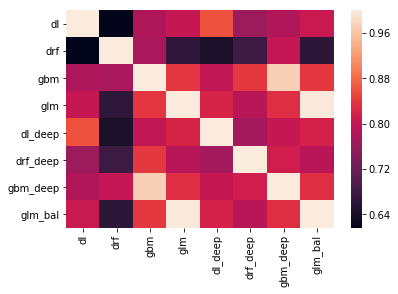

In [187]:
import seaborn as sns
corr = preds.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [192]:
pred = lgb2.predict(x_valid, num_iteration=lgb2.best_iteration)
pred.shape, preds.shape

((58288,), (58288, 8))

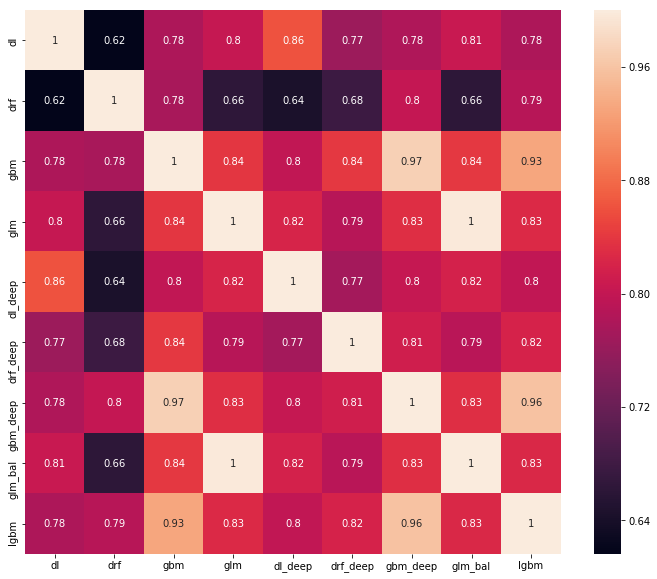

In [197]:
preds = pd.concat([preds, pd.DataFrame(data=pred,columns=['lgbm'])], axis=1)
import seaborn as sns
corr = preds.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [209]:
roc_score = {}
for col in preds.columns:
    roc_score[col] = roc_auc_score(y_valid, preds[col])
#     print(col.ljust(8), "==>", roc_auc_score(y_valid,preds[col]))
roc_score = pd.DataFrame(data=[roc_score.keys(), roc_score.values()]).T
roc_score.columns = ['model','roc']
roc_score['roc_norm'] = (roc_score.roc - roc_score.roc.min())/ \
                        (roc_score.roc.max() - roc_score.roc.min())

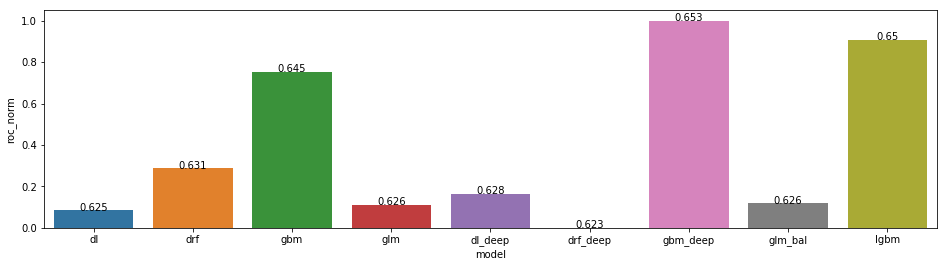

In [221]:
plt.figure(figsize=(16,4))
g = sns.barplot(x='model',y='roc_norm',data=roc_score)

for index, row in roc_score.iterrows():
    g.text(row.name,row.roc_norm, round(row.roc,3), color='black', ha="center")


In [198]:
train1 = h2o.H2OFrame(pd.concat([preds, target], axis=1))
# test  = h2o.H2OFrame(pd.concat([train_df, target], axis=1).drop(
#     ['disbursal_week', 'disbursal_day'], axis=1).iloc[valid_index])
# print(train.shape, test.shape)

# del train_df1, valid_df
gc.collect()

x = train1.columns
y = "loan_default"
x.remove(y)

# ignored_columns = ['UniqueID']
train1[y] = train1[y].asfactor()
# test[y]  = test[y].asfactor()

# aml = H2OAutoML(max_models=20, seed=1337, max_runtime_secs=14400, nfolds=3)
# aml.train(x = x, y = y,
#           training_frame = train,
#           leaderboard_frame = test)
# lb = aml.leaderboard
# lb.head(rows=lb.nrows)

gc.collect()

Parse progress: |█████████████████████████████████████████████████████████| 100%


0

gbm Model Build progress: |███████████████████████████████████████████████| 100%


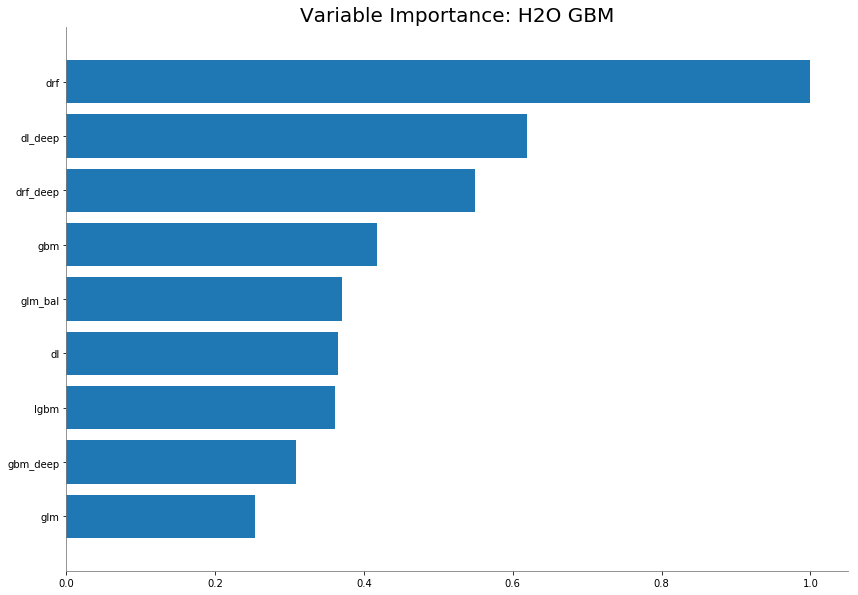

In [222]:
gbm_model_meta = H2OGradientBoostingEstimator()
gbm_model_meta.train(x, y, training_frame=train1)#, validation_frame=test)
gbm_model_meta.varimp_plot()

glm Model Build progress: |███████████████████████████████████████████████| 100%


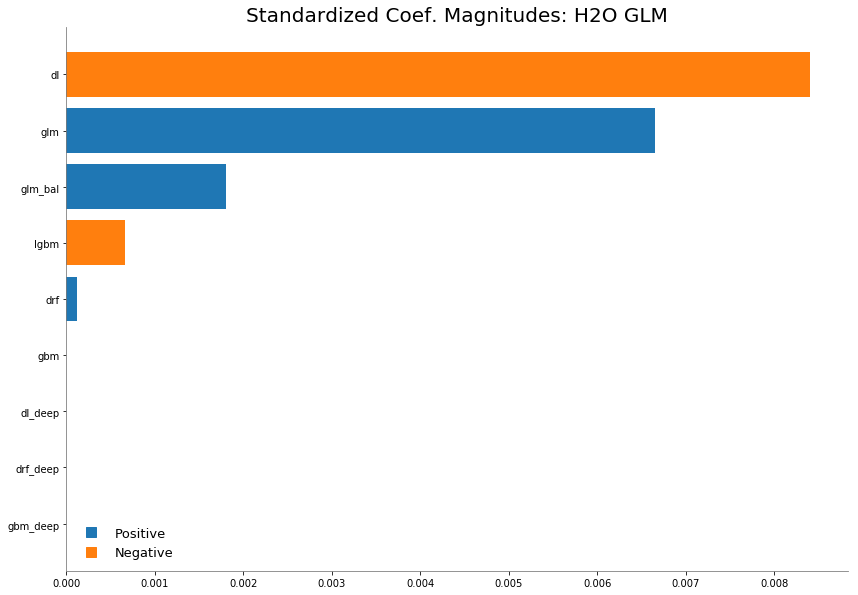

In [225]:
glm_model_meta = H2OGeneralizedLinearEstimator(family="binomial", 
                                              lambda_search=True,
                                              balance_classes=True)
glm_model_meta.train(x, y, training_frame=train1)#, validation_frame=test)
glm_model_meta.std_coef_plot()


In [227]:
glm_model_bal

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1555663391569_328


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15721448260372806
RMSE: 0.3965028153793212
LogLoss: 0.488951306812704
Null degrees of freedom: 174865
Residual degrees of freedom: 174824
Null deviance: 177926.8641156018
Residual deviance: 171001.9184342206
AIC: 171085.9184342206
AUC: 0.6395501273778413
Gini: 0.2791002547556827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1973200098954884: 


,0,1,Error,Rate
0,69701.0,69124.0,0.4979,(69124.0/138825.0)
1,10868.0,25173.0,0.3015,(10868.0/36041.0)
Total,80569.0,94297.0,0.4574,(79992.0/174866.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1973200,0.3862726,236.0
max f2,0.1293098,0.5744969,314.0
max f0point5,0.2505655,0.3227946,170.0
max accuracy,0.4951678,0.7939108,32.0
max precision,0.4951678,0.5040872,32.0
max recall,0.0016625,1.0,399.0
max specificity,0.9684359,0.9999928,0.0
max absolute_mcc,0.2061088,0.1641090,226.0
max min_per_class_accuracy,0.2160535,0.5988547,214.0
max mean_per_class_accuracy,0.2061088,0.6014157,226.0


Gains/Lift Table: Avg response rate: 20.61 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100019,0.4095436,2.2913888,2.2913888,0.4722699,0.4722699,0.0229183,0.0229183,129.1388775,129.1388775
,2,0.0200039,0.3758300,1.9057919,2.0985903,0.3927959,0.4325329,0.0190616,0.0419800,90.5791874,109.8590324
,3,0.0300001,0.3571765,1.8069582,2.0014167,0.3724256,0.4125048,0.0180628,0.0600427,80.6958189,100.1416674
,4,0.0400021,0.3435482,1.7643139,1.9421325,0.3636364,0.4002859,0.0176466,0.0776893,76.4313875,94.2132500
,5,0.0500040,0.3335257,1.6117396,1.8760464,0.3321898,0.3866651,0.0161205,0.0938098,61.1739562,87.6046355
,6,0.1000023,0.3016530,1.5455151,1.7107902,0.3185405,0.3526048,0.0772731,0.1710829,54.5515142,71.0790200
,7,0.1500006,0.2816302,1.4606089,1.6273996,0.3010408,0.3354175,0.0730279,0.2441109,46.0608924,62.7399620
,8,0.2000046,0.2669923,1.3761003,1.5645712,0.2836231,0.3224681,0.0688105,0.3129214,37.6100255,56.4571186
,9,0.3000011,0.2436638,1.2619395,1.4636978,0.2600938,0.3016775,0.1261896,0.4391110,26.1939473,46.3697795
,10,0.4000034,0.2237805,1.1700296,1.3902797,0.2411506,0.2865455,0.1170056,0.5561166,17.0029561,39.0279687




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18292881581801923
RMSE: 0.42770178374425705
LogLoss: 0.5508834674433378
Null degrees of freedom: 58287
Residual degrees of freedom: 58246
Null deviance: 66203.36922160786
Residual deviance: 64321.463153369165
AIC: 64405.463153369165
AUC: 0.6261606701062149
Gini: 0.2523213402124298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17718249591262442: 


,0,1,Error,Rate
0,18006.0,25712.0,0.5881,(25712.0/43718.0)
1,3462.0,11108.0,0.2376,(3462.0/14570.0)
Total,21468.0,36820.0,0.5005,(29174.0/58288.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1771825,0.4323020,261.0
max f2,0.0905986,0.6288908,353.0
max f0point5,0.2432195,0.3618127,176.0
max accuracy,0.6198176,0.7500515,14.0
max precision,0.6198176,0.5161290,14.0
max recall,0.0011427,1.0,399.0
max specificity,0.9856560,0.9999543,0.0
max absolute_mcc,0.1960100,0.1602377,237.0
max min_per_class_accuracy,0.2114072,0.5886363,216.0
max mean_per_class_accuracy,0.1960100,0.5922777,237.0


Gains/Lift Table: Avg response rate: 25.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100021,0.4002093,1.8321554,1.8321554,0.4579760,0.4579760,0.0183253,0.0183253,83.2155408,83.2155408
,2,0.0200041,0.3707123,1.7772594,1.8047074,0.4442539,0.4511149,0.0177763,0.0361016,77.7259365,80.4707386
,3,0.0300062,0.3515185,1.7429493,1.7841214,0.4356775,0.4459691,0.0174331,0.0535347,74.2949339,78.4121371
,4,0.0400082,0.3390373,1.5851232,1.7343718,0.3962264,0.4335334,0.0158545,0.0693892,58.5123218,73.4371832
,5,0.0500103,0.3294361,1.5165032,1.6907981,0.3790738,0.4226415,0.0151682,0.0845573,51.6503165,69.0798099
,6,0.1000034,0.2978209,1.4291598,1.5600014,0.3572409,0.3899468,0.0714482,0.1560055,42.9159775,56.0001380
,7,0.1500137,0.2780766,1.3682839,1.4960882,0.3420240,0.3739707,0.0684283,0.2244338,36.8283851,49.6088229
,8,0.2000069,0.2638064,1.3618890,1.4625442,0.3404255,0.3655859,0.0680851,0.2925189,36.1889046,46.2544189
,9,0.3000103,0.2413631,1.2662572,1.3971152,0.3165208,0.3492309,0.1266301,0.4191489,26.6257169,39.7115182
,10,0.3999966,0.2216614,1.1017298,1.3232783,0.2753946,0.3307742,0.1101579,0.5293068,10.1729798,32.3278338



Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2019-04-19 15:13:49,0.000 sec,1,.81E-1,1,1.0175041,1.1357976
,2019-04-19 15:13:49,0.117 sec,2,.73E-1,2,1.0161151,1.1344012
,2019-04-19 15:13:49,0.184 sec,3,.67E-1,2,1.0148837,1.1331859
,2019-04-19 15:13:49,0.227 sec,4,.61E-1,3,1.0132723,1.1316863
,2019-04-19 15:13:49,0.266 sec,5,.56E-1,3,1.0113747,1.1299877
---,---,---,---,---,---,---,---
,2019-04-19 15:13:54,5.586 sec,49,.93E-3,41,0.9781337,1.1035349
,2019-04-19 15:13:54,5.734 sec,50,.84E-3,41,0.9780624,1.1035220
,2019-04-19 15:13:55,5.989 sec,51,.77E-3,42,0.9779999,1.1035182
,2019-04-19 15:13:55,6.196 sec,52,.7E-3,42,0.9779478,1.1035151



See the whole table with table.as_data_frame()


In [155]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.5
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=50, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

# sub_df = pd.DataFrame({"ID_code":test_id})
# sub_df["target"] = predictions

# sub_df.columns = sub.columns
# sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

(174865,) (58289,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[50]	training's auc: 0.660532	valid_1's auc: 0.64924
[100]	training's auc: 0.662125	valid_1's auc: 0.650493
[150]	training's auc: 0.663824	valid_1's auc: 0.651822
[200]	training's auc: 0.66611	valid_1's auc: 0.65321
[250]	training's auc: 0.669116	valid_1's auc: 0.655472
[300]	training's auc: 0.671336	valid_1's auc: 0.656946
[350]	training's auc: 0.673914	valid_1's auc: 0.658606
[400]	training's auc: 0.676017	valid_1's auc: 0.659976
[450]	training's auc: 0.678017	valid_1's auc: 0.661093
[500]	training's auc: 0.680351	valid_1's auc: 0.662147
[550]	training's auc: 0.682148	valid_1's auc: 0.663052
[600]	training's auc: 0.683902	valid_1's auc: 0.663925
[650]	training's auc: 0.68565	valid_1's auc: 0.664514
[700]	training's auc: 0.687061	valid_1's auc: 0.664931
[750]	training's auc: 0.688567	valid_1's auc: 0.665451
[800]	training's auc: 0.690017	valid_1's auc: 0.665962
[850]	training's auc: 0.691388	valid_

KeyboardInterrupt: 

<BarContainer object of 49 artists>

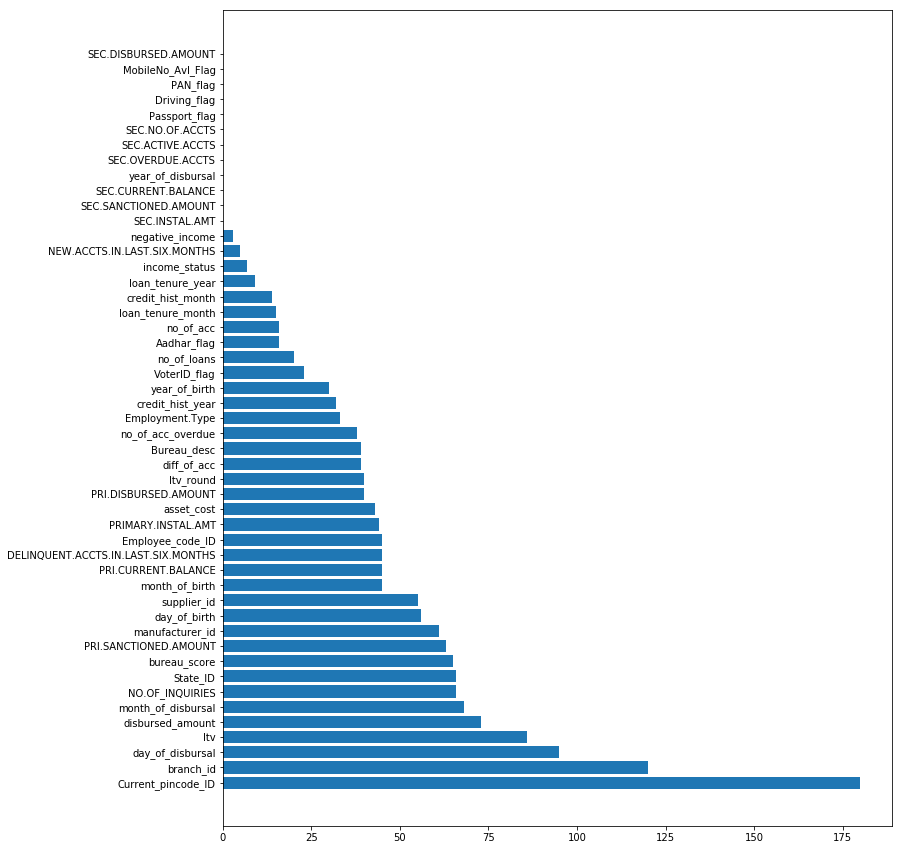

In [156]:
# lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
# lgb_imp.columns = ['feature','imp']
# lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
# plt.figure(figsize=(12,15))
# plt.barh(lgb_imp.feature, lgb_imp.imp)

In [160]:
del train_df, test_df
gc.collect()
train_df = train_df_save1.copy()
test_df = test_df_save1.copy()

# Let's investigate other columns

In [157]:
# 28 	SEC.NO.OF.ACCTS 	count of total loans taken by the customer at ... 	Secondary accounts are those which the custome...
# 29 	SEC.ACTIVE.ACCTS 	count of active loans taken by the customer at... 	NaN
# 30 	SEC.OVERDUE.ACCTS 	count of default accounts at the time of disbu... 	NaN

# 31 	SEC.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	NaN
# 32 	SEC.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
# 33 	SEC.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo...

cat_cols = ['SEC.ACTIVE.ACCTS', 'SEC.NO.OF.ACCTS','SEC.OVERDUE.ACCTS']
int_cols = ['SEC.CURRENT.BALANCE', 'SEC.DISBURSED.AMOUNT',
            'SEC.INSTAL.AMT','SEC.SANCTIONED.AMOUNT']

In [158]:
train_df[cat_cols].apply(lambda x: pd.Series.value_counts(x).shape[0])

SEC.ACTIVE.ACCTS     23
SEC.NO.OF.ACCTS      37
SEC.OVERDUE.ACCTS     9
dtype: int64

SEC.ACTIVE.ACCTS
(23, 3)


Text(0.5, 0.98, 'SEC.ACTIVE.ACCTS vs loan-default (in norm)')

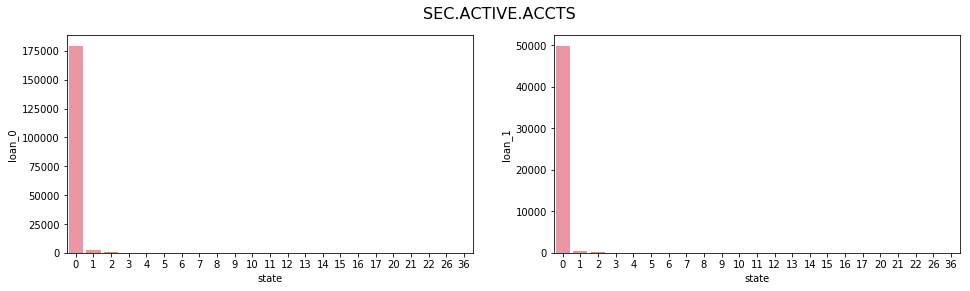

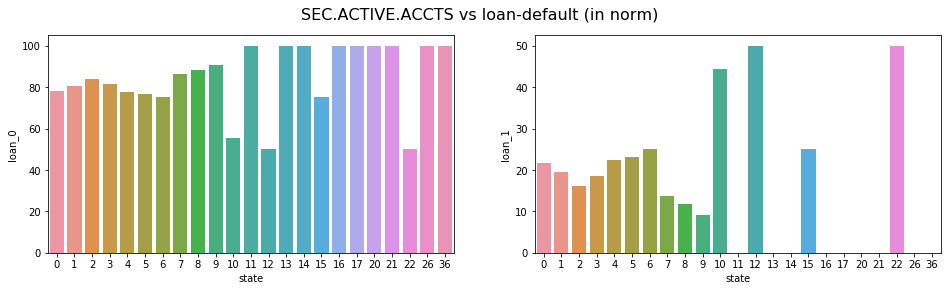

In [161]:
col = cat_cols[0]
print(col)
manufac_gps = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
manufac_gps.columns = ['loan_0', 'loan_1']
manufac_gps['state'] = manufac_gps.index
print(manufac_gps.shape)
# manufac_gps[['loan_0']] = 100*manufac_gps[['loan_0']]/train_df.shape[0]
# manufac_gps[['loan_1']] = 100*manufac_gps[['loan_1']]/train_df.shape[0]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col, fontsize=16)
    
    
manufac_gps[['loan_0','loan_1']] = 100*manufac_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)


fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col+' vs loan-default (in norm)', fontsize=16)


SEC.NO.OF.ACCTS
(37, 3)


Text(0.5, 0.98, 'SEC.NO.OF.ACCTS vs loan-default (in norm)')

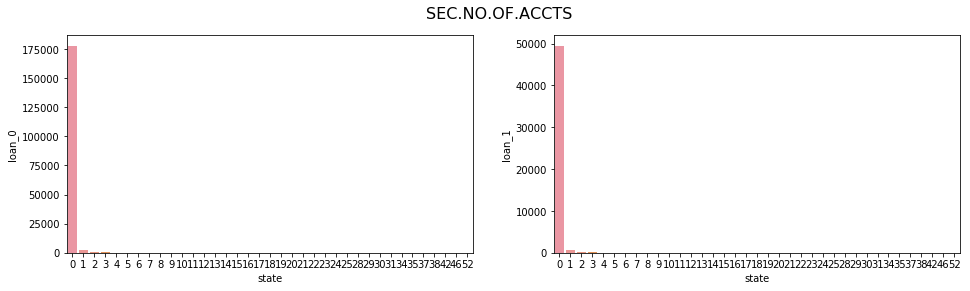

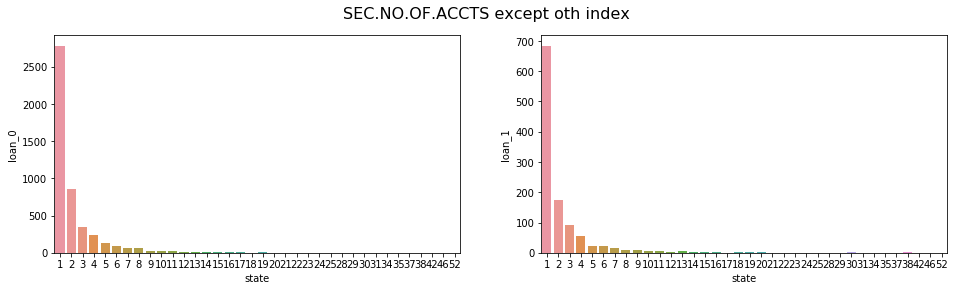

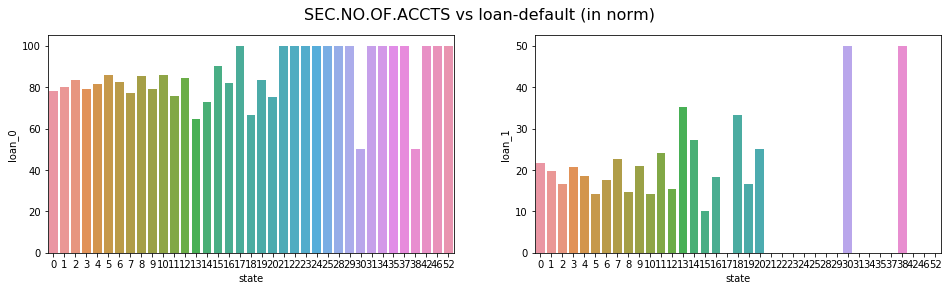

In [166]:
col = cat_cols[1]
print(col)
manufac_gps = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
manufac_gps.columns = ['loan_0', 'loan_1']
manufac_gps['state'] = manufac_gps.index
print(manufac_gps.shape)
# manufac_gps[['loan_0']] = 100*manufac_gps[['loan_0']]/train_df.shape[0]
# manufac_gps[['loan_1']] = 100*manufac_gps[['loan_1']]/train_df.shape[0]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col, fontsize=16)


fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps.iloc[1:,:], ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps.iloc[1:,:], ax=ax[1])#,label='1')
fig.suptitle(col+" except oth index", fontsize=16)

manufac_gps[['loan_0','loan_1']] = 100*manufac_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col+' vs loan-default (in norm)', fontsize=16)


SEC.OVERDUE.ACCTS
(9, 3)


Text(0.5, 0.98, 'SEC.OVERDUE.ACCTS vs loan-default (in norm)')

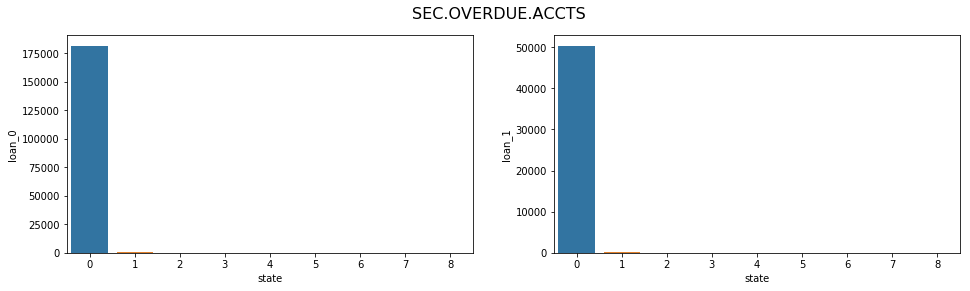

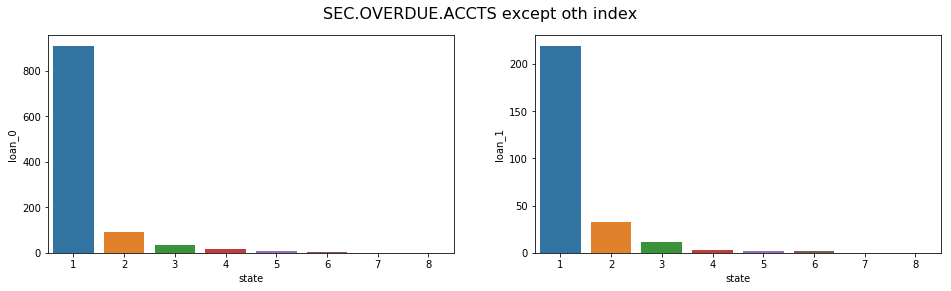

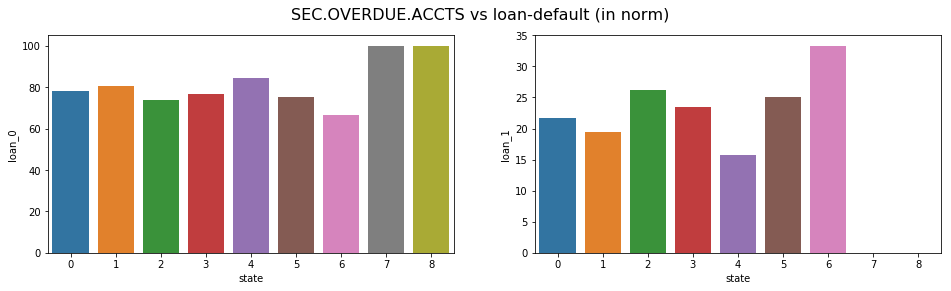

In [167]:
col = cat_cols[2]
print(col)
manufac_gps = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
manufac_gps.columns = ['loan_0', 'loan_1']
manufac_gps['state'] = manufac_gps.index
print(manufac_gps.shape)
# manufac_gps[['loan_0']] = 100*manufac_gps[['loan_0']]/train_df.shape[0]
# manufac_gps[['loan_1']] = 100*manufac_gps[['loan_1']]/train_df.shape[0]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col, fontsize=16)


fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps.iloc[1:,:], ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps.iloc[1:,:], ax=ax[1])#,label='1')
fig.suptitle(col+" except oth index", fontsize=16)


manufac_gps[['loan_0','loan_1']] = 100*manufac_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col+' vs loan-default (in norm)', fontsize=16)


In [168]:
train_df[cat_cols[0]].value_counts(), \
train_df[cat_cols[1]].value_counts(), \
train_df[cat_cols[2]].value_counts()

(0     229337
 1       2684
 2        636
 3        195
 4        116
 5         65
 6         32
 7         22
 8         17
 9         11
 10         9
 11         7
 12         6
 15         4
 13         3
 16         2
 22         2
 26         1
 14         1
 17         1
 20         1
 21         1
 36         1
 Name: SEC.ACTIVE.ACCTS, dtype: int64, 0     227289
 1       3466
 2       1036
 3        444
 4        292
 5        148
 6        119
 7         75
 8         68
 9         38
 10        35
 11        29
 13        17
 12        13
 16        11
 14        11
 15        10
 18         6
 19         6
 17         5
 20         4
 22         4
 23         4
 31         4
 21         3
 46         2
 24         2
 38         2
 30         2
 34         2
 37         1
 42         1
 28         1
 35         1
 29         1
 25         1
 52         1
 Name: SEC.NO.OF.ACCTS, dtype: int64, 0    231817
 1      1129
 2       126
 3        47
 4        19
 5         8
 6     

In [169]:
use_index = train_df[cat_cols[0]][train_df[cat_cols[0]]>0].index
train_df.loc[use_index, cat_cols[0]] = 1

use_index = train_df[cat_cols[1]][train_df[cat_cols[1]]>0].index
train_df.loc[use_index, cat_cols[1]] = 1

use_index = train_df[cat_cols[2]][train_df[cat_cols[2]]>0].index
train_df.loc[use_index, cat_cols[2]] = 1


# We need to categorize these `SEC` int columns

232642 233154


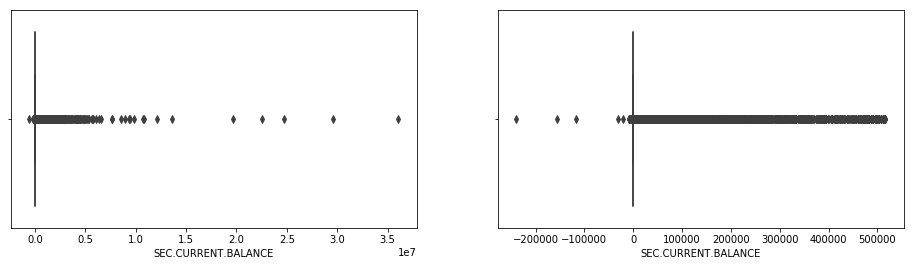

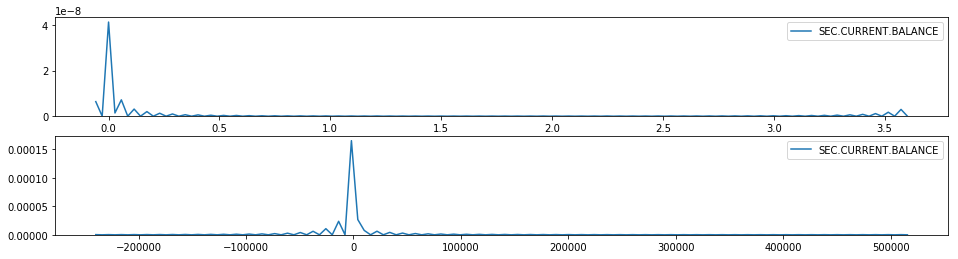

In [552]:
col = int_cols[0]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

232531 233154


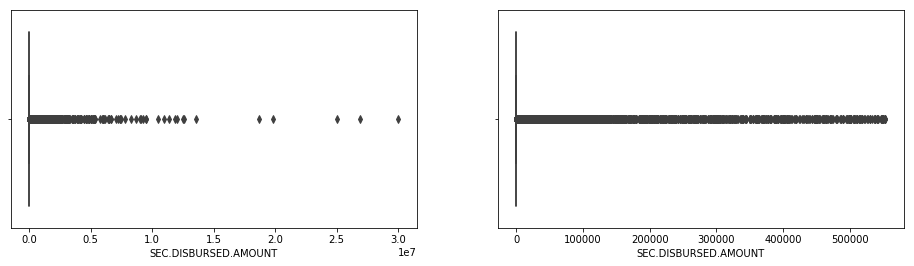

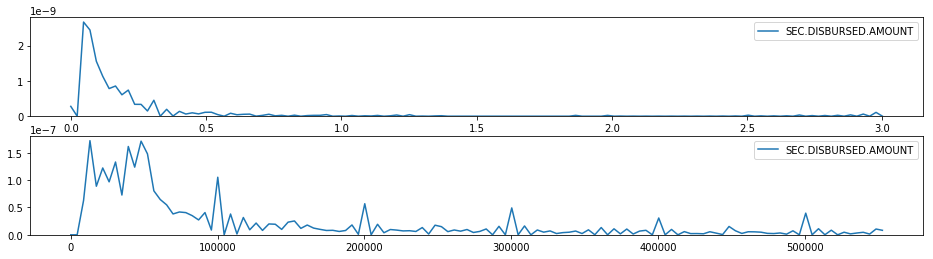

In [553]:
col = int_cols[1]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

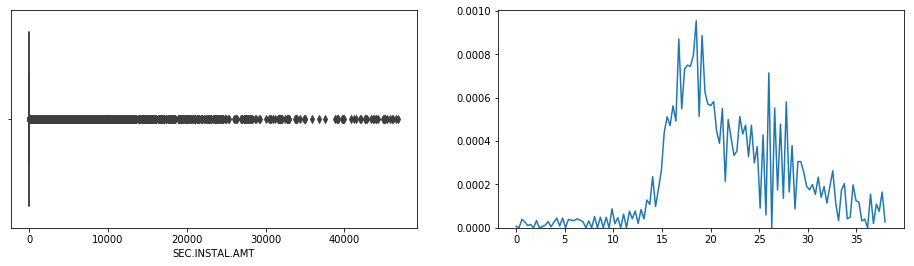

In [601]:
col = int_cols[2]
temp = train_df[train_df['PRI.CURRENT.BALANCE']<3000000][[int_cols[2]]]
tp = temp[col][(np.abs(stats.zscore(temp[[col]])) < 3).all(axis=1)]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(tp, ax=ax[0])
sns.kdeplot(boxcox(1+tp,lmbda=0.2),ax=ax[1])


In [603]:
tp[tp != 0]

154        9382
296        6485
316        1563
331        1065
403        1330
683        5185
710        2372
1538       1345
1589       3290
1718       9419
1759       1812
1768       2563
2038      12568
2113      14463
2212       1736
2215      10571
2247       4021
2262      15504
2286       1213
2302      45171
2308      12870
2362        433
2394       3171
2539       5813
2621       1676
2991      10575
3245       6889
3246       1534
3249        198
3280      20211
          ...  
226319    14870
226368      277
226508     7300
226793    19033
226988     4664
227666      982
229223    13302
229250     5000
229316      800
229849     6779
230169    10076
230233     1079
230239     3965
230247    17000
230399     2348
230431    10432
231198      625
231212     5082
231491    16807
231838     1232
231855      684
231868     2600
231967     2337
231970     4001
232159     9408
232173     1410
232174     1743
232348     2665
232675     2917
232829     3500
Name: SEC.INSTAL.AMT, Le

232912 233154


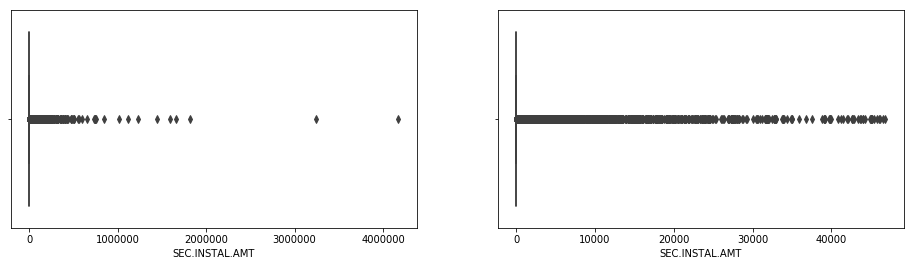

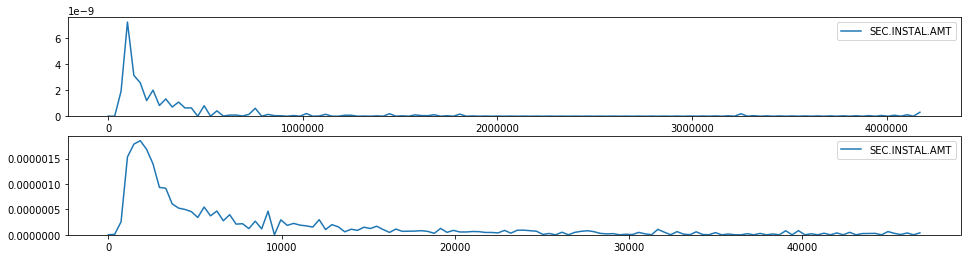

In [550]:
col = int_cols[2]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

232522 233154


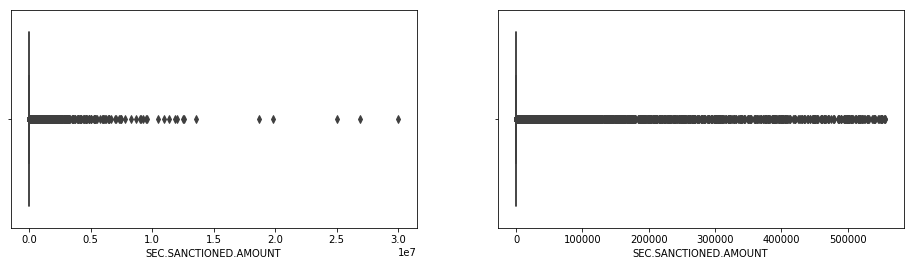

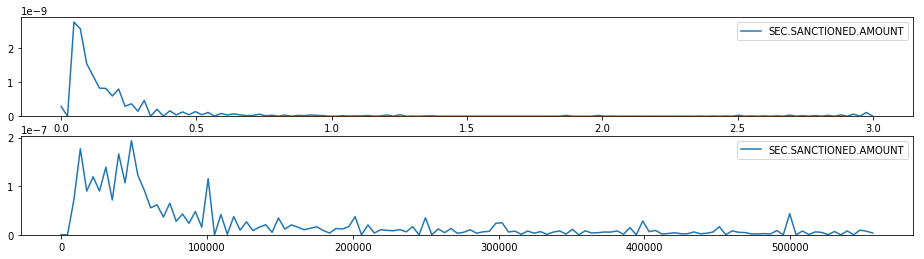

In [551]:
col = int_cols[3]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

In [176]:
int_cols

['SEC.CURRENT.BALANCE',
 'SEC.DISBURSED.AMOUNT',
 'SEC.INSTAL.AMT',
 'SEC.SANCTIONED.AMOUNT']

# I mess with `SEC.ACTIVE.ACCTS`, do all operation on this variable again

In [177]:
# New loans taken by the customer in last 6 mont... 	
train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

0     181494
1      32099
2      11015
3       4458
4       1957
5        964
6        480
7        302
8        147
9         79
10        55
11        31
12        20
13        15
14        11
16         6
17         6
20         3
15         2
18         2
19         2
23         2
28         1
21         1
22         1
35         1
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [178]:
use_index = train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'][
    train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS']>1].index
train_df.loc[use_index, 'NEW.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
print(train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'].value_counts())

use_index = test_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'][
    test_df['NEW.ACCTS.IN.LAST.SIX.MONTHS']>1].index
test_df.loc[use_index, 'NEW.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
print(test_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'].value_counts())


(19561,)
0    181494
1     32099
2     19561
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64
(7679,)
0    90847
1    13866
2     7679
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64


In [609]:
# DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS: When a loan defaults, it is sent to a debt collection agency whose job is to contact the borrower and receive the unpaid funds. 

train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

0     214959
1      14941
2       2470
3        537
4        138
5         58
6         20
7         13
8          7
12         3
11         3
10         2
9          2
20         1
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [179]:
use_index = train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'][
    train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']>1].index
train_df.loc[use_index, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
print(train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].value_counts())

use_index = test_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'][
    test_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']>1].index
test_df.loc[use_index, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
test_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

# train_df.groupby(['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','loan_default'])['loan_default'].count().unstack()

(3254,)
0    214959
1     14941
2      3254
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64
(1464,)


0    104185
1      6743
2      1464
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [ ]:
# 14 	MobileNo_Avl_Flag 	if Mobile no. was shared by the customer then ... 	NaN
# 15 	Aadhar_flag 	if aadhar was shared by the customer then flag... 	NaN
# 16 	PAN_flag 	if pan was shared by the customer then flagged... 	NaN
# 17 	VoterID_flag 	if voter was shared by the customer then flag... 	NaN
# 18 	Driving_flag 	if DL was shared by the customer then flagged ... 	NaN
# 19 	Passport_flag 	if passport was shared by the customer then fl... 	NaN


In [180]:
cols = ['MobileNo_Avl_Flag','Aadhar_flag','PAN_flag','VoterID_flag',
        'Driving_flag','Passport_flag']
train_df[cols].apply(lambda x: pd.Series.value_counts(x))

,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag
0,NaN,37230,215533,199360,227735,232658
1,233154.0,195924,17621,33794,5419,496


In [181]:
train_df.drop('MobileNo_Avl_Flag', axis=1, inplace=True)
test_df.drop('MobileNo_Avl_Flag', axis=1, inplace=True)


In [ ]:
# 0  UniqueID 	Identifier for customers 	NaN
# 1  loan_default 	Payment default in the first EMI on due date 	NaN
# 2  disbursed_amount 	Amount of Loan disbursed 	NaN
# 3  asset_cost 	Cost of the Asset 	NaN
# 4  ltv 	Loan to Value of the asset 	NaN
# 5  branch_id 	Branch where the loan was disbursed 	NaN
# 6  supplier_id 	Vehicle Dealer where the loan was disbursed 	NaN
# 7  manufacturer_id 	Vehicle manufacturer(Hero, Honda, TVS etc.) 	NaN
# 8  Current_pincode 	Current pincode of the customer 	NaN
# 9  Date.of.Birth 	Date of birth of the customer 	NaN
# 10 Employment.Type 	Employment Type of the customer (Salaried/Self... 	NaN
# 11 DisbursalDate 	Date of disbursement 	NaN
# 12 State_ID 	State of disbursement 	NaN
# 13 Employee_code_ID 	Employee of the organization who logged the di... 	NaN

# 22 PRI.NO.OF.ACCTS 	count of total loans taken by the customer at ... 	Primary accounts are those which the customer ...
# 23 PRI.ACTIVE.ACCTS 	count of active loans taken by the customer at... 	NaN
# 24 PRI.OVERDUE.ACCTS 	count of default accounts at the time of disbu... 	NaN
# 25 PRI.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	NaN
# 26 PRI.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
# 27 PRI.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo... 	NaN
# 28 SEC.NO.OF.ACCTS 	count of total loans taken by the customer at ... 	Secondary accounts are those which the custome...
# 29 SEC.ACTIVE.ACCTS 	count of active loans taken by the customer at... 	NaN
# 30 SEC.OVERDUE.ACCTS 	count of default accounts at the time of disbu... 	NaN
# 31 SEC.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	NaN
# 32 SEC.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
# 33 SEC.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo... 	NaN
# 34 PRIMARY.INSTAL.AMT 	EMI Amount of the primary loan 	NaN
# 35 SEC.INSTAL.AMT 	EMI Amount of the secondary loan 	NaN
# 36 NEW.ACCTS.IN.LAST.SIX.MONTHS 	New loans taken by the customer in last 6 mont... 	NaN
# 37 DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS 	Loans defaulted in the last 6 months 	NaN
# 38 AVERAGE.ACCT.AGE 	Average loan tenure 	NaN
# 39 CREDIT.HISTORY.LENGTH 	Time since first loan 	NaN
# 40 NO.OF_INQUIRIES 	Enquries done by the customer for loans 	NaN

In [189]:
cols = ['day_of_birth','month_of_birth','year_of_birth',
        'day_of_disbursal','month_of_disbursal','year_of_disbursal',
        'credit_hist_year','credit_hist_month',
        'loan_tenure_year','loan_tenure_month']

train_df[cols] = train_df[cols].astype('int')
test_df[cols]  = test_df[cols].astype('int')

train_df['credit_history'] = train_df['credit_hist_year']*12+train_df['credit_hist_month']
test_df['credit_history'] = test_df['credit_hist_year']*12+test_df['credit_hist_month']

In [646]:
# train_df.groupby(['day_of_birth','month_of_birth','year_of_birth','loan_default'])['loan_default'].count().unstack()
# train_df.groupby(['credit_hist_year','credit_hist_month','loan_default'])['loan_default'].count().unstack()


In [190]:
train_df.credit_history.value_counts().sort_index()

0      119127
1        1853
2        1977
3        1982
4        2143
5        2086
6        4761
7        4017
8        2459
9        2403
10       2367
11       2627
12       3389
13       3024
14       2203
15       2268
16       1882
17       1868
18       2176
19       2167
20       1643
21       1811
22       1818
23       2364
24       3833
25       4745
26       1793
27       1407
28       1378
29       1376
        ...  
279         1
280         1
282         2
288         1
290         1
292         2
295         2
296         1
300         1
306         2
307         2
308         1
311         1
315         1
320         1
323         1
327         1
328         1
337         1
339         1
343         1
345         1
349         1
355         2
367         1
369         1
413         1
423         1
449         1
468         1
Name: credit_history, Length: 294, dtype: int64

In [673]:
# train_df.credit_hist_year.value_counts().sort_index()

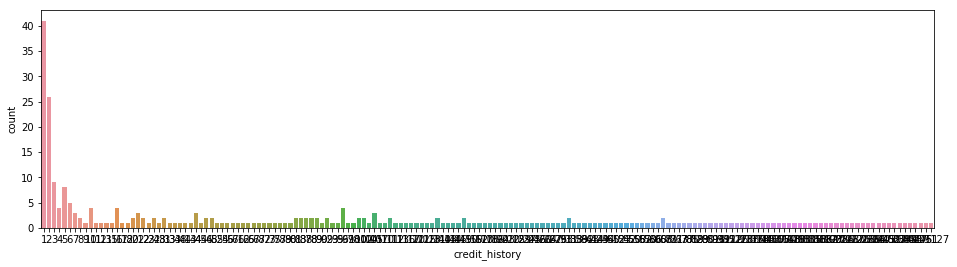

In [191]:
plt.figure(figsize=(16,4))
sns.countplot(train_df.credit_history.value_counts())

In [192]:
bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 12), (12, 24), 
                                     (24, 36), (36, 60), (60, 120), (120,500)])
train_df['credit_history'] = pd.cut(train_df.credit_history, bins)
test_df['credit_history'] = pd.cut(test_df.credit_history, bins)

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 1), (1, 3), (3, 6), (6, 9), (9, 50)])
train_df['credit_hist_year'] = pd.cut(train_df.credit_hist_year, bins)
test_df['credit_hist_year'] = pd.cut(test_df.credit_hist_year, bins)

print(train_df.credit_history.value_counts())
print(train_df.credit_hist_year.value_counts())


(-1, 0]       119127
(0, 12]        32064
(12, 24]       27057
(24, 36]       20462
(36, 60]       18388
(60, 120]      11793
(120, 500]      4263
Name: credit_history, dtype: int64
(-1, 0]    147802
(1, 3]      34511
(0, 1]      26613
(3, 6]      15446
(6, 9]       4423
(9, 50]      4359
Name: credit_hist_year, dtype: int64


In [193]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df['credit_history']) + list(test_df['credit_history']))
print(le.classes_)
train_df['credit_history'] = le.transform(train_df['credit_history'])
test_df['credit_history']  = le.transform(test_df['credit_history'])

le.fit(list(train_df['credit_hist_year']) + list(test_df['credit_hist_year']))
print(le.classes_)
train_df['credit_hist_year'] = le.transform(train_df['credit_hist_year'])
test_df['credit_hist_year']  = le.transform(test_df['credit_hist_year'])


[Interval(-1, 0, closed='right') Interval(0, 12, closed='right')
 Interval(12, 24, closed='right') Interval(24, 36, closed='right')
 Interval(36, 60, closed='right') Interval(60, 120, closed='right')
 Interval(120, 500, closed='right')]
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 3, closed='right') Interval(3, 6, closed='right')
 Interval(6, 9, closed='right') Interval(9, 50, closed='right')]


# Also try, if category further can be reduced or grouped

In [674]:
train_df[['day_of_disbursal','month_of_disbursal','year_of_disbursal']]

,day_of_disbursal,month_of_disbursal,year_of_disbursal
0,8,3,2018
1,26,9,2018
2,8,1,2018
3,26,10,2018
4,26,9,2018
5,19,9,2018
6,23,9,2018
7,16,9,2018
8,9,5,2018
9,16,9,2018


In [194]:
train_df.drop('year_of_disbursal',axis=1, inplace=True)
test_df.drop('year_of_disbursal',axis=1, inplace=True)


In [195]:
train_df.month_of_disbursal.value_counts()

10    84875
8     56975
9     54443
11     6709
6      5991
12     5613
3      5148
4      4627
7      4150
5      2890
1      1708
2        25
Name: month_of_disbursal, dtype: int64

In [196]:
train_df.loan_tenure_year.value_counts()

0     168390
1      36650
2      14839
3       6622
4       3033
5       1600
6        810
7        467
8        234
9        150
10       129
11       102
12        57
13        35
14        15
15        10
16         5
17         2
24         1
18         1
22         1
30         1
Name: loan_tenure_year, dtype: int64

In [197]:
train_df.loan_tenure_month.value_counts()

0     127976
6      11085
1      10117
7       9881
4       9757
3       9720
2       9682
5       9519
8       8936
10      8842
9       8842
11      8797
Name: loan_tenure_month, dtype: int64

In [198]:
train_df['loan_tenure'] = train_df['loan_tenure_year']*12+train_df['loan_tenure_month']
test_df['loan_tenure']  = test_df['loan_tenure_year']*12+test_df['loan_tenure_month']

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 12), (12, 24), (24, 60), (60,500)])
train_df['loan_tenure'] = pd.cut(train_df.loan_tenure, bins)
test_df['loan_tenure'] = pd.cut(test_df.loan_tenure, bins)

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 1), (1, 2), (2, 5), (5, 10), (10, 50)])
train_df['loan_tenure_year'] = pd.cut(train_df.loan_tenure_year, bins)
test_df['loan_tenure_year'] = pd.cut(test_df.loan_tenure_year, bins)

print(train_df.loan_tenure.value_counts())
print(train_df.loan_tenure_year.value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df['loan_tenure']) + list(test_df['loan_tenure']))
print(le.classes_)
train_df['loan_tenure'] = le.transform(train_df['loan_tenure'])
test_df['loan_tenure']  = le.transform(test_df['loan_tenure'])

le.fit(list(train_df['loan_tenure_year']) + list(test_df['loan_tenure_year']))
print(le.classes_)
train_df['loan_tenure_year'] = le.transform(train_df['loan_tenure_year'])
test_df['loan_tenure_year']  = le.transform(test_df['loan_tenure_year'])


(-1, 0]      119373
(0, 12]       54048
(12, 24]      33582
(24, 60]      22715
(60, 500]      3436
Name: loan_tenure, dtype: int64
(-1, 0]     168390
(0, 1]       36650
(1, 2]       14839
(2, 5]       11255
(5, 10]       1790
(10, 50]       230
Name: loan_tenure_year, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 12, closed='right')
 Interval(12, 24, closed='right') Interval(24, 60, closed='right')
 Interval(60, 500, closed='right')]
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 5, closed='right')
 Interval(5, 10, closed='right') Interval(10, 50, closed='right')]


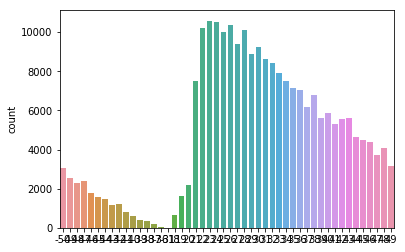

In [199]:
sns.countplot(train_df_save['year_of_disbursal'] - train_df['year_of_birth'])

In [751]:
sorted(test_df['year_of_birth'].unique())

[1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2054,
 2055,
 2056,
 2057,
 2058,
 2059,
 2060,
 2061,
 2062,
 2063,
 2064,
 2065,
 2066,
 2067,
 2068]

In [201]:
train_df.year_of_birth = train_df.year_of_birth.apply(lambda x: int(str(19)+str(x)[-2:]))
test_df.year_of_birth  = test_df.year_of_birth.apply(lambda x: int(str(19)+str(x)[-2:]))

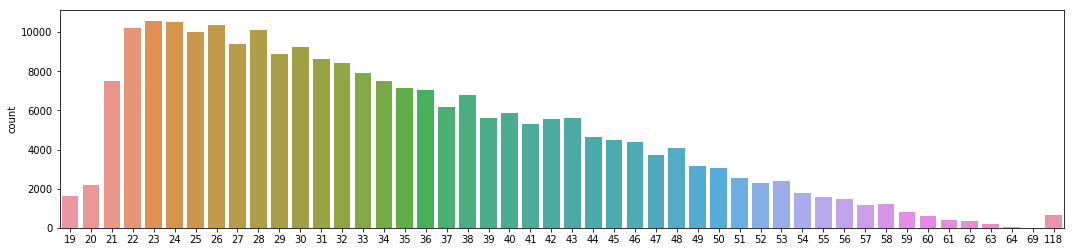

In [202]:
plt.figure(figsize=(18,4))
sns.countplot(train_df_save['year_of_disbursal'] - train_df['year_of_birth'])

In [203]:
train_df['age_till_disbursal'] = train_df_save['year_of_disbursal'] - train_df['year_of_birth']
test_df['age_till_disbursal']  = test_df_save['year_of_disbursal'] - test_df['year_of_birth']

In [758]:
train_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,...,loan_tenure_year,loan_tenure_month,day_of_disbursal,month_of_disbursal,Bureau_desc,bureau_score,loan_default,credit_history,loan_tenure,age_till_disbursal
0,420825,50578,58400,89.55,67,22807,45,1441,0,6,...,0,0,8,3,13,0,0,0,0,34
1,537409,47145,65550,73.23,67,22807,45,1502,1,6,...,1,11,26,9,8,598,1,2,2,33
2,417566,53278,61360,89.63,67,22807,45,1497,1,6,...,0,0,8,1,13,0,0,0,0,33
3,624493,57513,66113,88.48,67,22807,45,1501,1,6,...,0,8,26,10,11,305,1,2,1,25
4,539055,52378,60300,88.39,67,22807,45,1495,1,6,...,0,0,26,9,13,0,1,0,0,41


232432 233154


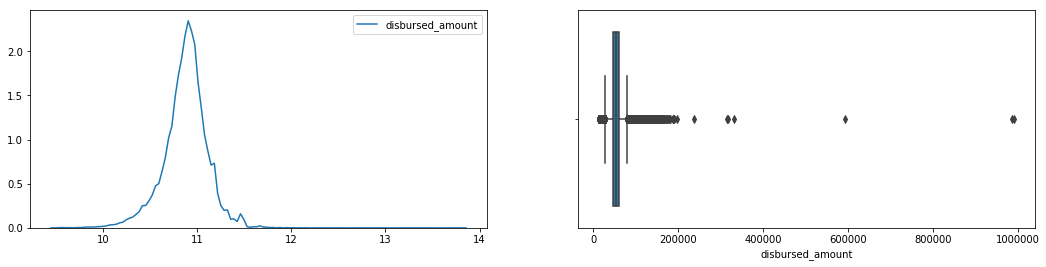

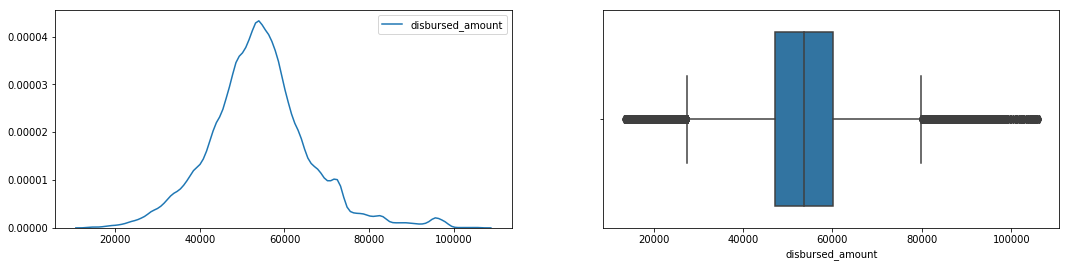

In [214]:
col = 'disbursed_amount'

fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(np.log(train_df[col]), ax=ax[0])
sns.boxplot(train_df[col], ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 4).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

# sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])


In [221]:
train_df[col][train_df[col]>100000].shape, test_df[col][test_df[col]>100000].shape

((835,), (530,))

(835,)
(530,)


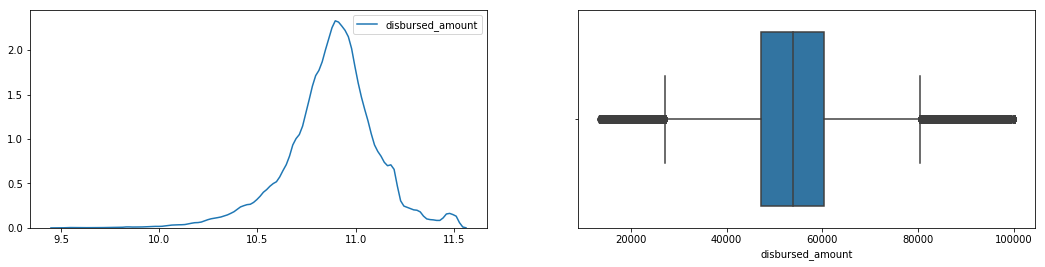

In [223]:
col = 'disbursed_amount'

use_index = train_df[col][train_df[col]>100000].index
train_df.loc[use_index, col] = 100000
print(use_index.shape)

use_index = test_df[col][test_df[col]>100000].index
test_df.loc[use_index, col] = 100000
print(use_index.shape)

fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(np.log(train_df[col]), ax=ax[0])
sns.boxplot(train_df[col], ax=ax[1])


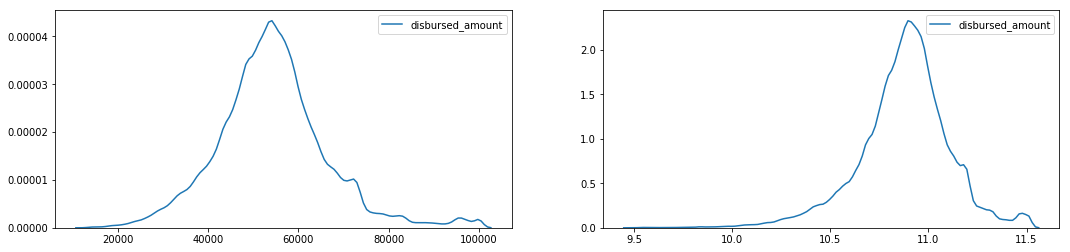

In [225]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0])
sns.kdeplot(np.log(train_df[col]), ax=ax[1])


230465 233154


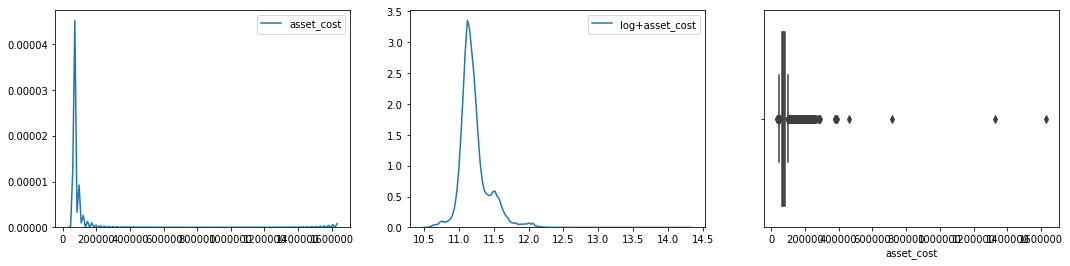

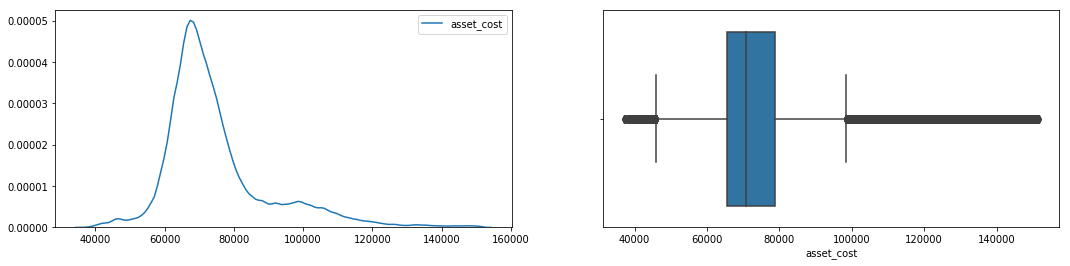

In [229]:
col = 'asset_cost'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 4).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

# sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])


In [235]:
train_df[col][train_df[col]>170000].shape, test_df[col][test_df[col]>170000].shape

((1091,), (630,))

(0,)
(0,)


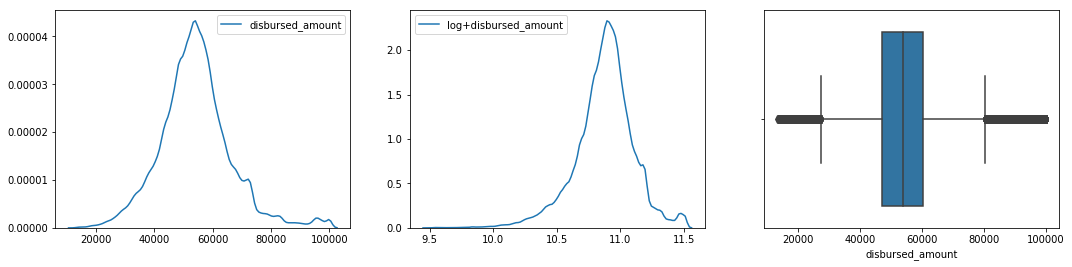

In [236]:
col = 'disbursed_amount'

use_index = train_df[col][train_df[col]>170000].index
train_df.loc[use_index, col] = 170000
print(use_index.shape)

use_index = test_df[col][test_df[col]>170000].index
test_df.loc[use_index, col] = 170000
print(use_index.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])


230409 233154


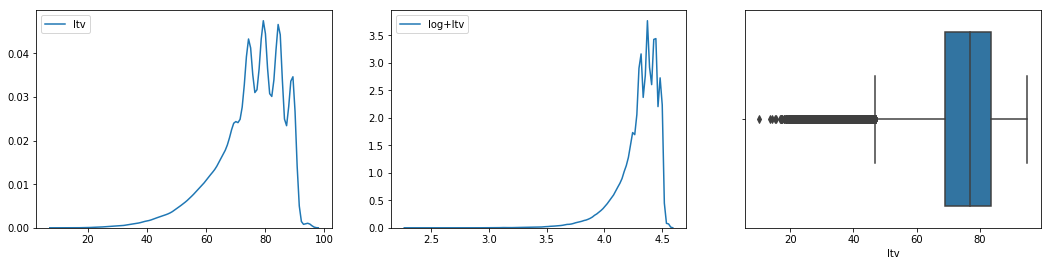

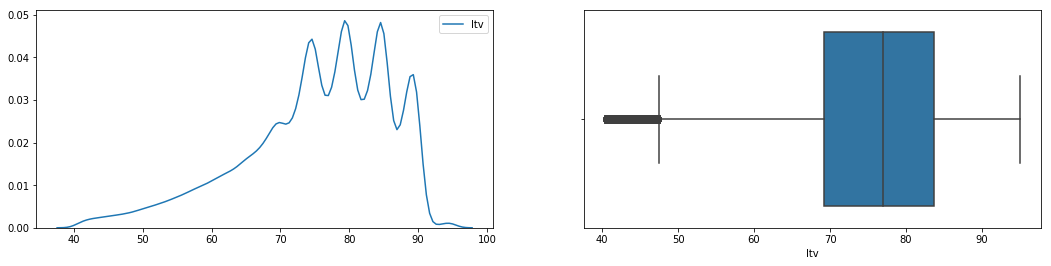

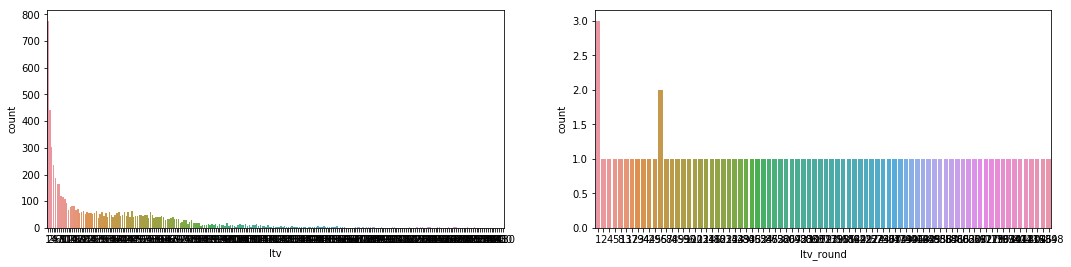

In [244]:
col = 'ltv'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(18,4))
bar = train_df.ltv.value_counts()
sns.countplot(bar, ax=ax[0])
bar = train_df.ltv_round.value_counts()
sns.countplot(bar, ax=ax[1])

# sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])


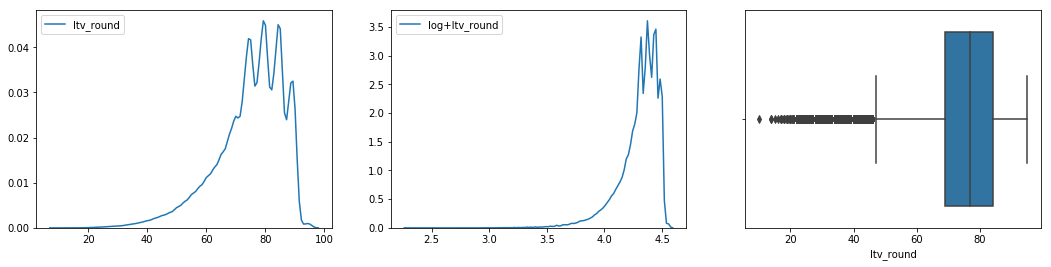

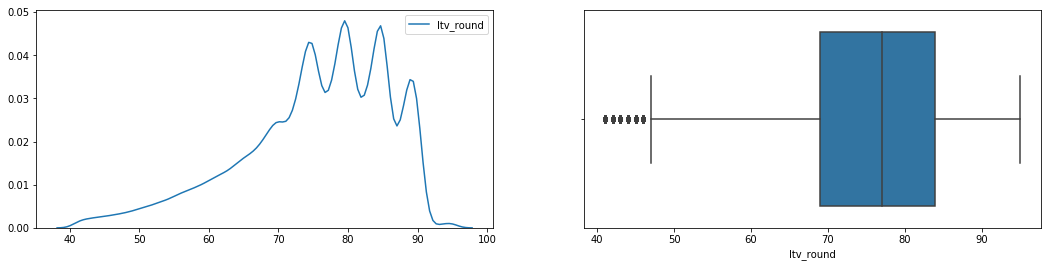

In [262]:
col = 'ltv_round'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

In [245]:
train_df.ltv_round.value_counts().sort_index()

10.0        1
14.0        2
15.0        1
16.0        1
17.0        5
18.0        4
19.0        8
20.0       13
21.0       17
22.0       29
23.0       42
24.0       34
25.0       49
26.0       57
27.0       56
28.0       96
29.0       84
30.0      100
31.0       95
32.0      122
33.0      146
34.0      180
35.0      181
36.0      243
37.0      235
38.0      280
39.0      352
40.0      354
41.0      387
42.0      463
        ...  
66.0     3996
67.0     4199
68.0     4885
69.0     5387
70.0     6320
71.0     4986
72.0     5883
73.0     7118
74.0    10480
75.0    12116
76.0     6020
77.0     6627
78.0     7767
79.0    11404
80.0    13639
81.0     5841
82.0     6392
83.0     7130
84.0     9804
85.0    15848
86.0     4006
87.0     4229
88.0     5865
89.0     9741
90.0     9334
91.0       56
92.0       85
93.0      134
94.0      249
95.0      346
Name: ltv_round, Length: 83, dtype: int64

In [263]:
col = 'ltv_round'
new_col = 'ltv_round_cat'

bins_ = [(9.99, 57.0), (57.0, 64.0), (64.0, 69.0), (69.0, 72.0), 
        (72.0, 75.0), (75.0, 77.0), (77.0, 79.0), (79.0, 81.0), 
        (81.0, 84.0), (84.0, 85.0), (85.0, 89.0), (89.0, 95.0)]

bins = pd.IntervalIndex.from_tuples(bins_)
train_df[new_col] = pd.cut(train_df[col], bins)
test_df[new_col]  = pd.cut(test_df[col], bins)
print(train_df[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df[new_col]) + list(test_df[new_col]))
print(le.classes_)
train_df[new_col] = le.transform(train_df[new_col])
test_df[new_col]  = le.transform(test_df[new_col])


(72.0, 75.0]    29714
(85.0, 89.0]    23841
(81.0, 84.0]    23326
(64.0, 69.0]    22207
(9.99, 57.0]    20283
(79.0, 81.0]    19480
(57.0, 64.0]    19244
(77.0, 79.0]    19171
(69.0, 72.0]    17189
(84.0, 85.0]    15848
(75.0, 77.0]    12647
(89.0, 95.0]    10204
Name: ltv_round_cat, dtype: int64
[Interval(9.99, 57.0, closed='right') Interval(57.0, 64.0, closed='right')
 Interval(64.0, 69.0, closed='right') Interval(69.0, 72.0, closed='right')
 Interval(72.0, 75.0, closed='right') Interval(75.0, 77.0, closed='right')
 Interval(77.0, 79.0, closed='right') Interval(79.0, 81.0, closed='right')
 Interval(81.0, 84.0, closed='right') Interval(84.0, 85.0, closed='right')
 Interval(85.0, 89.0, closed='right') Interval(89.0, 95.0, closed='right')]


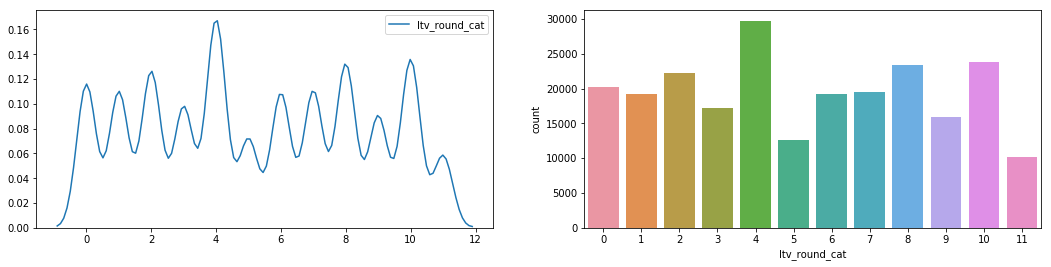

In [267]:
col = 'ltv_round_cat'

fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.countplot(train_df[col], ax=ax[1])

In [268]:
train_df.drop('ltv_round', axis=1, inplace=True)
test_df.drop('ltv_round', axis=1, inplace=True)


In [277]:
train_df['NO.OF_INQUIRIES'].value_counts()

col = 'NO.OF_INQUIRIES'
new_col = 'no_of_inquiry'

bins_ = [(-1,0),(0,1),(1,3),(3,100)]

bins = pd.IntervalIndex.from_tuples(bins_)
train_df[new_col] = pd.cut(train_df[col], bins)
test_df[new_col]  = pd.cut(test_df[col], bins)
print(train_df[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df[new_col]) + list(test_df[new_col]))
print(le.classes_)
train_df[new_col] = le.transform(train_df[new_col])
test_df[new_col]  = le.transform(test_df[new_col])

train_df.drop(col, axis=1, inplace=True)
test_df.drop(col, axis=1, inplace=True)


(-1, 0]     201961
(0, 1]       22285
(1, 3]        7176
(3, 100]      1732
Name: no_of_inquiry, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 3, closed='right') Interval(3, 100, closed='right')]


In [282]:
train_df['SEC.INSTAL.AMT'].value_counts()

0         230937
2100           7
1100           6
5000           6
1065           6
1232           6
2400           5
1565           5
1834           5
50000          5
833            5
1167           5
3334           4
2500           4
2065           4
2250           4
1149           4
1              4
1375           4
1750           4
3000           4
100000         4
1850           4
4500           4
2542           4
1650           4
2150           3
1877           3
231            3
10000          3
           ...  
26846          1
299843         1
55882          1
11210          1
181000         1
81000          1
9419           1
3278           1
17735          1
5581           1
7756           1
1615           1
4046           1
43333          1
19033          1
2769           1
4946           1
4563           1
3025           1
5330           1
7379           1
105699         1
23899          1
3537           1
1616           1
1744           1
6098           1
2256          

In [285]:
col = 'SEC.INSTAL.AMT'

train_df[col][train_df[col]==0].shape

(230937,)

In [286]:
col = 'SEC.INSTAL.AMT'

use_index = train_df[col][train_df[col]!=0].index
train_df.loc[use_index, col] = 1
print(use_index.shape)

use_index = test_df[col][test_df[col]!=0].index
test_df.loc[use_index, col] = 1
print(use_index.shape)


(2217,)
(488,)


In [287]:
train_df[col].value_counts()

0    230937
1      2217
Name: SEC.INSTAL.AMT, dtype: int64

/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


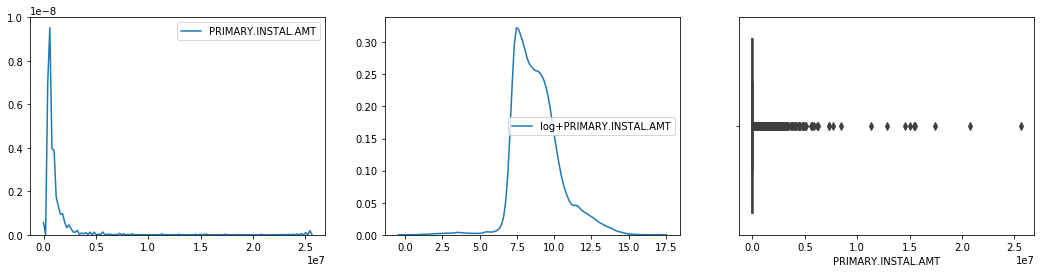

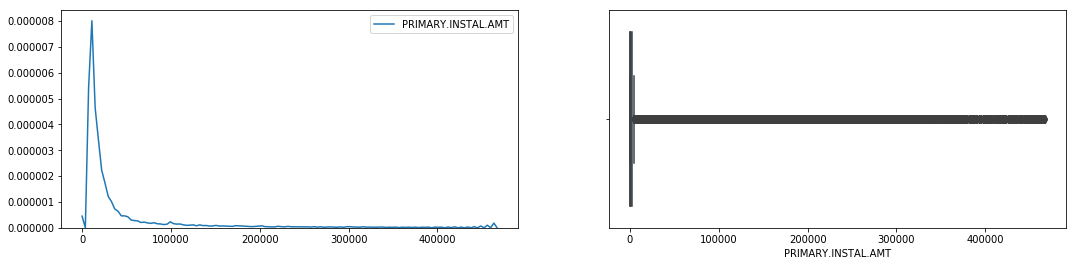

In [289]:
col = 'PRIMARY.INSTAL.AMT'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

In [295]:
train_df[col][train_df[col]>600000].shape, test_df[col][test_df[col]>600000].shape

((944,), (359,))

(1181,)
(449,)


/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


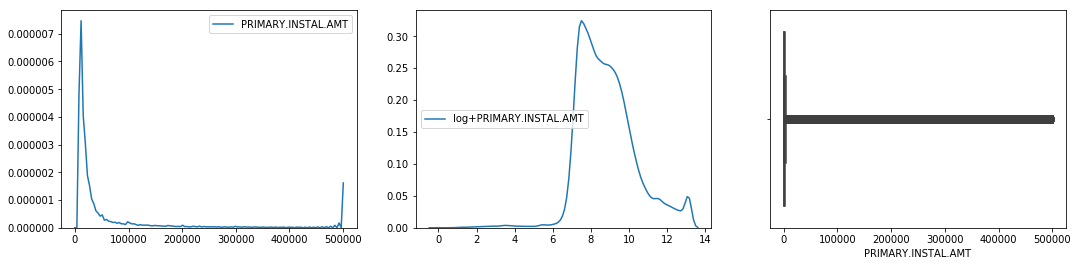

In [296]:
col = 'PRIMARY.INSTAL.AMT'

use_index = train_df[col][train_df[col]>500000].index
train_df.loc[use_index, col] = 500000
print(use_index.shape)

use_index = test_df[col][test_df[col]>500000].index
test_df.loc[use_index, col] = 500000
print(use_index.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])


In [300]:
train_df[col][train_df[col]>100000].shape, test_df[col][test_df[col]>100000].shape

((4854,), (1908,))

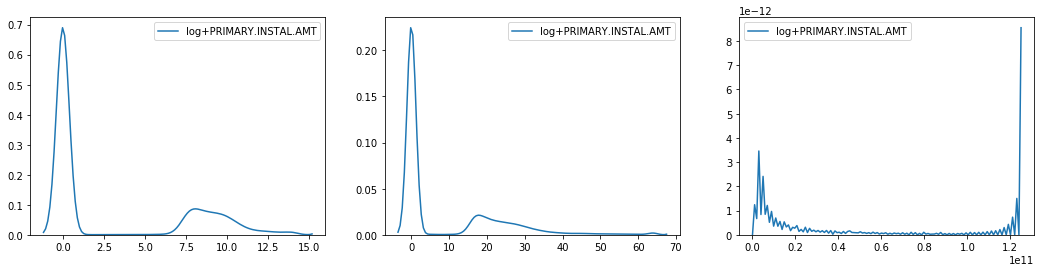

In [312]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
# sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.01), ax=ax[0], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.2), ax=ax[1], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=2), ax=ax[2], label='log+'+col)


In [319]:
train_df[col][train_df[col]<100000].shape, test_df[col][test_df[col]<100000].shape,\
np.percentile(train_df[col],98)

((228214,), (110451,), 106000.0)

Before:  (233154, 52)
After:  (228214, 52)


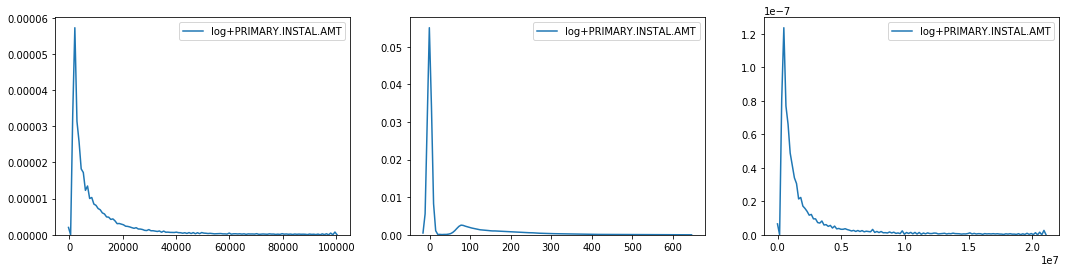

In [320]:
print("Before: ", train_df.shape)
train_df = train_df[train_df[col]<100000]
print("After: ", train_df.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
# sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1), ax=ax[0], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.5), ax=ax[1], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1.5), ax=ax[2], label='log+'+col)


In [325]:
train_df[col][train_df[col]<20000].shape, test_df[col][test_df[col]<20000].shape,\
np.percentile(train_df[col],95)

((218429,), (106178,), 17618.349999999977)

Before:  (228214, 52)
After:  (224607, 52)


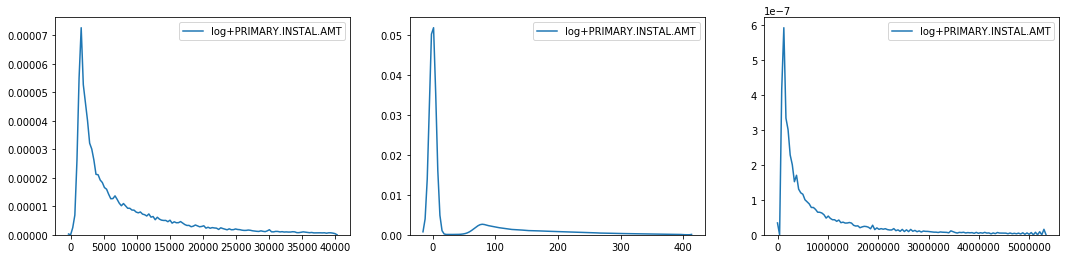

In [326]:
print("Before: ", train_df.shape)
train_df = train_df[train_df[col]<40000]
print("After: ", train_df.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
# sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1), ax=ax[0], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.5), ax=ax[1], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1.5), ax=ax[2], label='log+'+col)


In [329]:
train_df_save2 = train_df.copy()
test_df_save2  = test_df.copy()

train_df.drop(['UniqueID','loan_default'], axis=1, inplace=True)
test_df.drop('UniqueID', axis=1, inplace=True)

train_df.reset_index(drop=True, inplace=True)
target = train_df_save2.loan_default
test_id = test_df_save2.UniqueID

train_df_save.shape, train_df_save1.shape, train_df_save2.shape, train_df.shape

((233154, 47), (233154, 51), (224607, 52), (224607, 50))

In [341]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=50, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[50]	training's auc: 0.658055	valid_1's auc: 0.649907
[100]	training's auc: 0.660458	valid_1's auc: 0.652178
[150]	training's auc: 0.66301	valid_1's auc: 0.653871
[200]	training's auc: 0.665726	valid_1's auc: 0.655789
[250]	training's auc: 0.66781	valid_1's auc: 0.657361
[300]	training's auc: 0.670516	valid_1's auc: 0.659152
[350]	training's auc: 0.672434	valid_1's auc: 0.660358
[400]	training's auc: 0.674801	valid_1's auc: 0.661921
[450]	training's auc: 0.677013	valid_1's auc: 0.663092
[500]	training's auc: 0.678963	valid_1's auc: 0.664193
[550]	training's auc: 0.680733	valid_1's auc: 0.664862
[600]	training's auc: 0.682542	valid_1's auc: 0.665879
[650]	training's auc: 0.68421	valid_1's auc: 0.6668
[700]	training's auc: 0.685769	valid_1's auc: 0.667288
[750]	training's auc: 0.687284	valid_1's auc: 0.66786
[800]	training's auc: 0.688819	valid_1's auc: 0.668482
[850]	training's auc: 0.690387	valid_1'

NameError: name 'sub' is not defined

In [336]:
train_df_save.to_csv('store_data/train_df_save.csv',index=None)
train_df_save1.to_csv('store_data/train_df_save1.csv',index=None)
train_df_save2.to_csv('store_data/train_df_save2.csv',index=None)

test_df_save.to_csv('store_data/test_df_save.csv',index=None)
test_df_save1.to_csv('store_data/test_df_save1.csv',index=None)
test_df_save2.to_csv('store_data/test_df_save2.csv',index=None)



In [337]:
del train_df_save, train_df_save1, test_df_save, test_df_save1
gc.collect()

2635

In [339]:
gc.collect()
gc.collect()
gc.collect()

0

In [340]:
train_df_save2.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
       'Employment.Type', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'loan_default', 'day_of_birth',
       'month_of_birth', 'year_of_birth', 'credit_hist_year',
       'credit_hist_month', 'loan_tenure_year', 'loan_tenure_month',
       'day_of_disbursal', 'month_of_disbursal', 'Bureau_desc', 'bureau_score',
       'no_of_loans', 'no_of_acc', 'no_of_acc_overdue', 'diff_of_acc',
       'negative_income', 'income_status', 'credit_history'

In [344]:
train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])

disbursed_amount                       23592
asset_cost                             45522
ltv                                     6556
branch_id                                 82
supplier_id                             2946
manufacturer_id                           11
Current_pincode_ID                      6601
Employment.Type                            2
State_ID                                  22
Employee_code_ID                        3268
Aadhar_flag                                2
PAN_flag                                   2
VoterID_flag                               2
Driving_flag                               2
Passport_flag                              2
PRI.CURRENT.BALANCE                    64301
PRI.SANCTIONED.AMOUNT                  40168
PRI.DISBURSED.AMOUNT                   43426
SEC.NO.OF.ACCTS                            2
SEC.ACTIVE.ACCTS                           2
SEC.OVERDUE.ACCTS                          2
SEC.CURRENT.BALANCE                     3042
SEC.SANCTI

In [352]:
train_df = train_df_save2.copy()
test_df  = test_df_save2.copy()


In [393]:
print("Before: ", train_df.shape)

train_df['inst_per_year'] = train_df['disbursed_amount']/1.0*(1+train_df['loan_tenure_year'])
test_df['inst_per_year']  = test_df['disbursed_amount']/1.0*(1+test_df['loan_tenure_year'])

train_df['inst_per_month'] = train_df['disbursed_amount']/1.0*(\
                    1+train_df['credit_hist_year']*12 + train_df['credit_hist_month'])
test_df['inst_per_month']  = test_df['disbursed_amount']/1.0*(\
                    1+test_df['credit_hist_year']*12 + test_df['credit_hist_month'])

train_df['inst_per_credit_year'] = (train_df['disbursed_amount']/(1+train_df['credit_hist_year']))
test_df['inst_per_credit_year']  = (test_df['disbursed_amount']/(1+test_df['credit_hist_year']))

train_df['inst_per_credit_month'] = train_df['disbursed_amount']/1.0*(\
                    1+train_df['credit_hist_year']*12 + train_df['credit_hist_month'])
test_df['inst_per_credit_month']  = test_df['disbursed_amount']/1.0*(\
                    1+test_df['credit_hist_year']*12 + test_df['credit_hist_month'])

train_df['loan_tenure/credit(in month)'] = (
    (train_df['loan_tenure_year']*12 +train_df['loan_tenure_month'])/(
    1+train_df['credit_hist_year']*12 + train_df['credit_hist_month'])).fillna(0)
test_df['loan_tenure/credit(in month)'] = (
    (test_df['loan_tenure_year']*12 + test_df['loan_tenure_month'])/(
    1+test_df['credit_hist_year']*12 + test_df['credit_hist_month'])).fillna(0)


train_df['assest-disbursed'] = train_df['asset_cost'] - train_df['disbursed_amount']
test_df['assest-disbursed'] = test_df['asset_cost'] - test_df['disbursed_amount']

print("After: ", train_df.shape)


Before:  (224607, 52)
After:  (224607, 58)


In [394]:
train_df_save2 = train_df.copy()
test_df_save2  = test_df.copy()

train_df.drop(['UniqueID','loan_default'], axis=1, inplace=True)
test_df.drop('UniqueID', axis=1, inplace=True)

train_df.reset_index(drop=True, inplace=True)
target = train_df_save2.loan_default
test_id = test_df_save2.UniqueID

train_df_save.shape, train_df_save1.shape, train_df_save2.shape, train_df.shape

NameError: name 'train_df_save' is not defined

(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[50]	training's auc: 0.653119	valid_1's auc: 0.64377
[100]	training's auc: 0.656524	valid_1's auc: 0.647822
[150]	training's auc: 0.65992	valid_1's auc: 0.650291
[200]	training's auc: 0.663109	valid_1's auc: 0.653117
[250]	training's auc: 0.665918	valid_1's auc: 0.655329
[300]	training's auc: 0.669244	valid_1's auc: 0.657633
[350]	training's auc: 0.671601	valid_1's auc: 0.659124
[400]	training's auc: 0.674506	valid_1's auc: 0.661122
[450]	training's auc: 0.676944	valid_1's auc: 0.662334
[500]	training's auc: 0.679117	valid_1's auc: 0.663302
[550]	training's auc: 0.681125	valid_1's auc: 0.664202
[600]	training's auc: 0.682997	valid_1's auc: 0.665139
[650]	training's auc: 0.684779	valid_1's auc: 0.665947
[700]	training's auc: 0.686553	valid_1's auc: 0.666592
[750]	training's auc: 0.688141	valid_1's auc: 0.667154
[800]	training's auc: 0.689791	valid_1's auc: 0.667681
[850]	training's auc: 0.691359	vali

<BarContainer object of 56 artists>

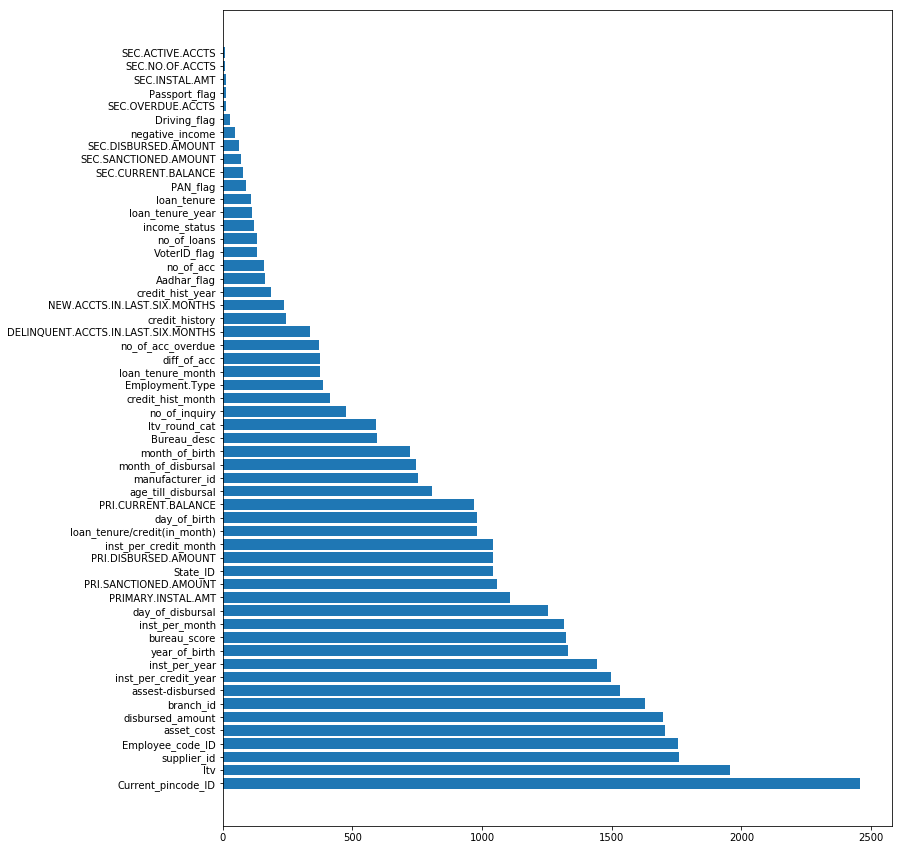

In [401]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline1'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=200, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

In [402]:
!ls submission/

check.zip  lightgbm_target_baseline1.csv  lightgbm_target_baseline.csv


In [403]:
!zip submission/lightgbm_target_baseline1.zip submission/lightgbm_target_baseline1.csv

  adding: submission/lightgbm_target_baseline1.csv (deflated 54%)


In [404]:
del train_df, test_df
train_df = train_df_save2.copy()
test_df  = test_df_save2.copy()


In [440]:
del branch_gps, state_gps, manufac_gps
gc.collect()

6463

In [469]:
print("check status: ", len(set(train_df['branch_id']).intersection(
    set(test_df['branch_id']))), \
    len(set(test_df['branch_id'])), len(set(train_df['branch_id'])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby(['branch_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['branch_id','branch_asset_amt_mean','branch_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on='branch_id', how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby(['branch_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['branch_id','branch_asset_amt_mean','branch_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on='branch_id', how='left')
print("After", test_df.shape)

check status:  82 82 82
Before:  (224607, 58)
After (224607, 60)
Before:  (112392, 57)
After (112392, 59)


In [483]:
print("check status: ", len(set(train_df['supplier_id']).intersection(
    set(test_df['supplier_id']))), \
    len(set(test_df['supplier_id'])), len(set(train_df['supplier_id'])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby(['supplier_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['supplier_id','supplier_asset_amt_mean','supplier_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on='supplier_id', how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby(['supplier_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['supplier_id','supplier_asset_amt_mean','supplier_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on='supplier_id', how='left')
print("After", test_df.shape)

check status:  2725 2863 2946


/home/ankish/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Before:  (224607, 60)
After (224607, 62)
Before:  (112392, 59)
After (112392, 61)


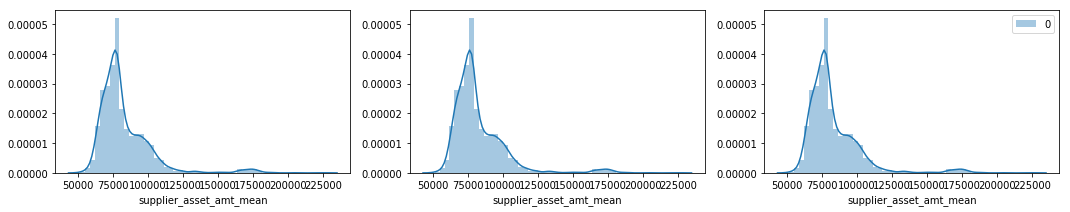

In [484]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp['supplier_asset_amt_mean'].fillna(
    branch_gp['supplier_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp['supplier_asset_amt_mean'].fillna(
    branch_gp['supplier_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp['supplier_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [488]:
col = 'manufacturer_id'
half_col = 'manufacturer'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  10 11 11
Before:  (224607, 62)


/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


After (224607, 64)
Before:  (112392, 61)
After (112392, 63)


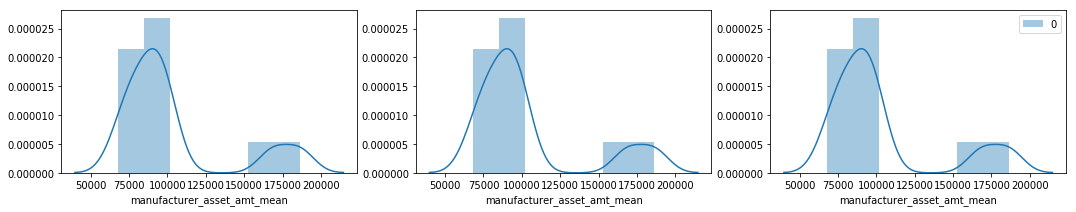

In [489]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [491]:
col = 'State_ID'
half_col = 'State'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  22 22 22
Before:  (224607, 64)
After (224607, 66)
Before:  (112392, 63)
After (112392, 65)


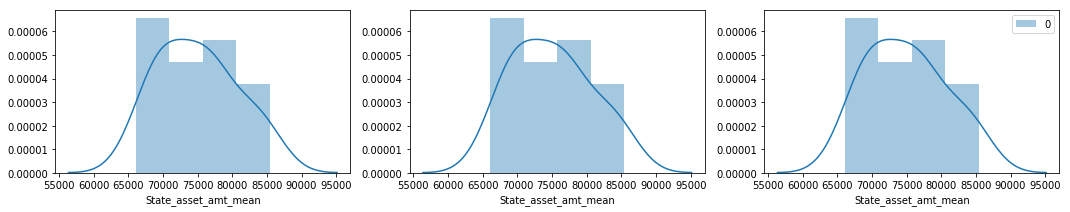

In [492]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

check status:  5766 6202 6601


In [494]:
col = 'Employee_code_ID'
half_col = 'Employee'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  3014 3143 3268


/home/ankish/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Before:  (224607, 66)
After (224607, 68)
Before:  (112392, 65)
After (112392, 67)


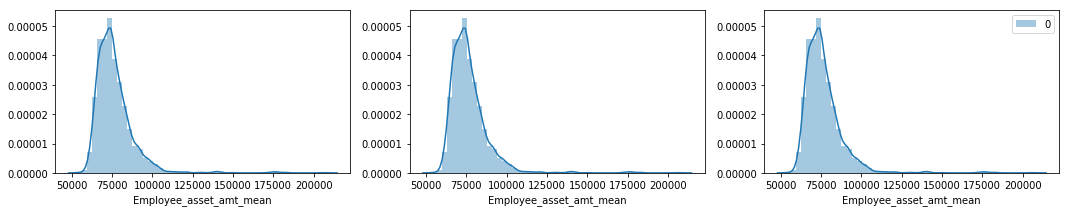

In [495]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [497]:
col = 'Current_pincode_ID'
half_col = 'Pincode'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  5766 6202 6601


/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Before:  (224607, 68)
After (224607, 70)
Before:  (112392, 67)
After (112392, 69)


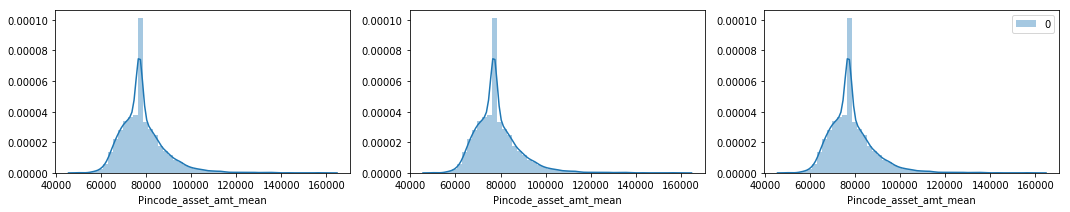

In [498]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [499]:
train_df_save2 = train_df.copy()
test_df_save2  = test_df.copy()

train_df.drop(['UniqueID','loan_default'], axis=1, inplace=True)
test_df.drop('UniqueID', axis=1, inplace=True)

train_df.reset_index(drop=True, inplace=True)
target = train_df_save2.loan_default
test_id = test_df_save2.UniqueID

train_df_save2.shape, train_df.shape

((224607, 70), (224607, 68))

(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.664969	valid_1's auc: 0.654364
[400]	training's auc: 0.678074	valid_1's auc: 0.663229
[600]	training's auc: 0.687379	valid_1's auc: 0.667844
[800]	training's auc: 0.694686	valid_1's auc: 0.670587
[1000]	training's auc: 0.701048	valid_1's auc: 0.672158
[1200]	training's auc: 0.706892	valid_1's auc: 0.673335
[1400]	training's auc: 0.712329	valid_1's auc: 0.674078
[1600]	training's auc: 0.717554	valid_1's auc: 0.674611
Early stopping, best iteration is:
[1710]	training's auc: 0.720367	valid_1's auc: 0.674995
  auc =  0.6749945388719458
(168455,) (56152,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.664653	valid_1's auc: 0.656581
[400]	training's auc: 0.67772	valid_1's auc: 0.664912
[600]	training's auc: 0.687251	valid_1's auc: 0.66943
[800]	training's auc: 0.694569	valid_1's auc: 0.671929
[1000]	training's auc: 0.701071	valid_1's a

<BarContainer object of 68 artists>

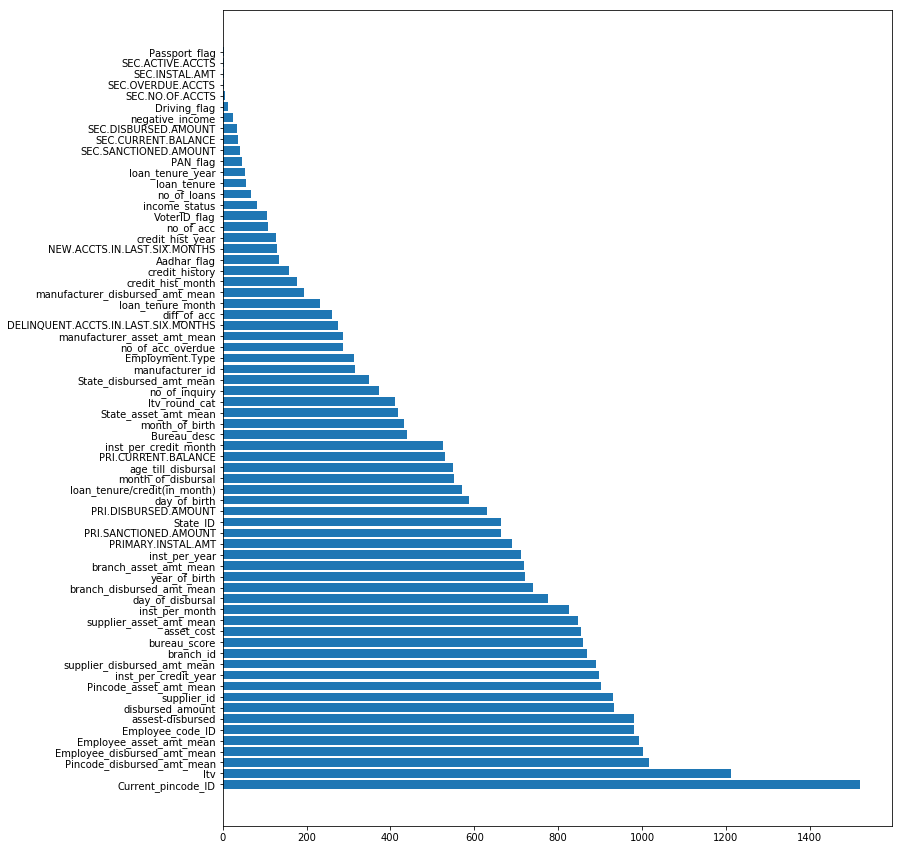

In [500]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline2'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=200, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

In [501]:
!zip submission/lightgbm_target_baseline2.zip submission/lightgbm_target_baseline2.csv

  adding: submission/lightgbm_target_baseline2.csv (deflated 54%)


In [502]:
train_df.drop(['Current_pincode_ID','Employee_code_ID','supplier_id'], axis=1, inplace=True)
test_df.drop(['Current_pincode_ID','Employee_code_ID','supplier_id'], axis=1, inplace=True)


(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.662914	valid_1's auc: 0.652765
[400]	training's auc: 0.676361	valid_1's auc: 0.661829
[600]	training's auc: 0.685285	valid_1's auc: 0.666189
[800]	training's auc: 0.69236	valid_1's auc: 0.668699
[1000]	training's auc: 0.698597	valid_1's auc: 0.670331
[1200]	training's auc: 0.704315	valid_1's auc: 0.671337
[1400]	training's auc: 0.709611	valid_1's auc: 0.672051
[1600]	training's auc: 0.714717	valid_1's auc: 0.672719
Early stopping, best iteration is:
[1642]	training's auc: 0.715787	valid_1's auc: 0.672846
  auc =  0.6728462858449251
(168455,) (56152,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.662134	valid_1's auc: 0.654462
[400]	training's auc: 0.675403	valid_1's auc: 0.663477
[600]	training's auc: 0.684809	valid_1's auc: 0.668085
[800]	training's auc: 0.692212	valid_1's auc: 0.670704
[1000]	training's auc: 0.698546	valid_1's 

<BarContainer object of 65 artists>

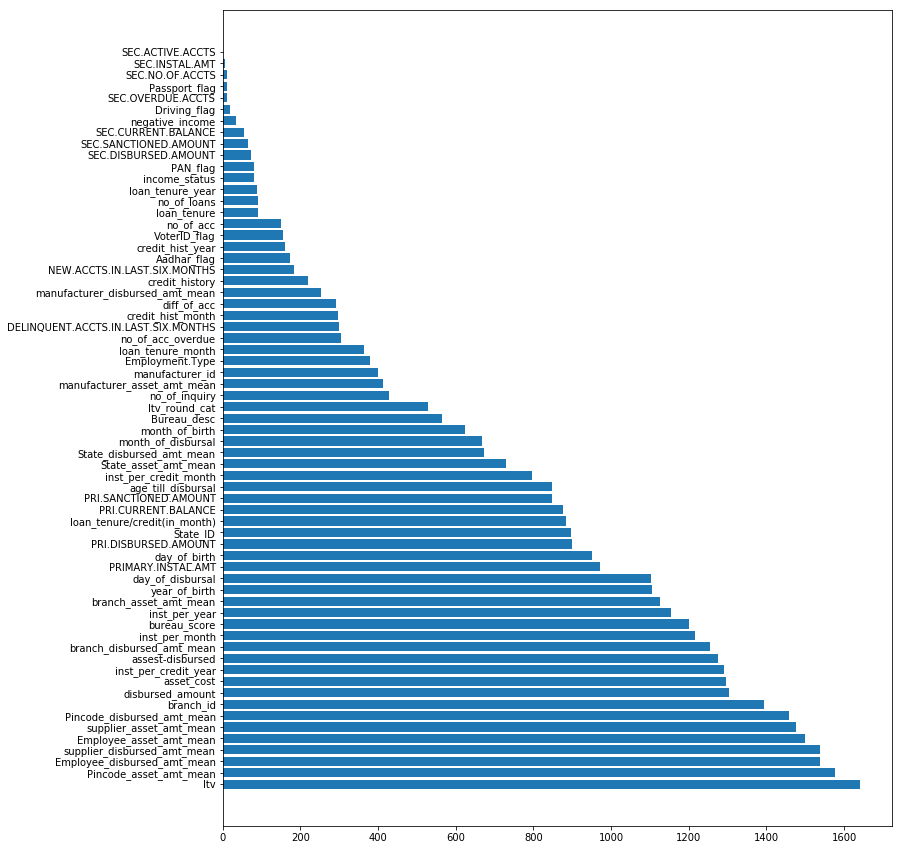

In [503]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline3'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=200, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

In [504]:
!zip submission/lightgbm_target_baseline3.zip submission/lightgbm_target_baseline3.csv

  adding: submission/lightgbm_target_baseline3.csv (deflated 54%)
